In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bitcoin = pd.read_csv('Bitcoin1.csv', sep=';')
bitcoin = bitcoin.iloc[::-1].reset_index(drop=True)


In [16]:
print(len(bitcoin))
print(bitcoin.columns)
print(bitcoin.dtypes)

4990
Index(['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 'open', 'high',
       'low', 'close', 'volume', 'marketCap', 'timestamp'],
      dtype='object')
timeOpen      object
timeClose     object
timeHigh      object
timeLow       object
name           int64
open         float64
high         float64
low          float64
close        float64
volume       float64
marketCap    float64
timestamp     object
dtype: object


In [28]:
print(bitcoin.name.unique())
print('Min: ', bitcoin.close.min(), '/', 'Max: ', bitcoin.close.max())
print(bitcoin.timestamp.min(), '/', bitcoin.timestamp.max())

[2781]
Min:  0.05640216 / Max:  69019.7863638058
2010-07-13T23:59:59.999Z / 2024-03-10T23:59:59.999Z


In [21]:
bitcoin.describe()

name          open          high           low         close  \
count  4990.0   4990.000000   4990.000000   4990.000000   4990.000000   
mean   2781.0  10637.429418  10887.288210  10374.185174  10650.373939   
std       0.0  15607.658183  15982.658573  15208.576051  15626.558619   
min    2781.0      0.056403      0.061552      0.048647      0.056402   
25%    2781.0    226.140003    230.526745    222.466003    226.398750   
50%    2781.0   1734.214966   1812.895020   1690.275024   1746.895020   
75%    2781.0  14663.475342  15485.707338  13794.399902  14688.450195   
max    2781.0  68500.255854  70083.051624  68239.980387  69019.786364   

             volume     marketCap  
count  4.990000e+03  4.990000e+03  
mean   1.168221e+10  1.995255e+11  
std    1.773942e+10  2.980340e+11  
min    0.000000e+00  1.902596e+05  
25%    2.141742e+05  3.185439e+09  
50%    7.514705e+08  2.852100e+10  
75%    2.026604e+10  2.544138e+11  
max    3.509679e+11  1.356284e+12

In [37]:
bitcoin.isnull().mean()

timeOpen     0.0
timeClose    0.0
timeHigh     0.0
timeLow      0.0
name         0.0
open         0.0
high         0.0
low          0.0
close        0.0
volume       0.0
marketCap    0.0
timestamp    0.0
dtype: float64

Text(0, 0.5, 'Frequency')

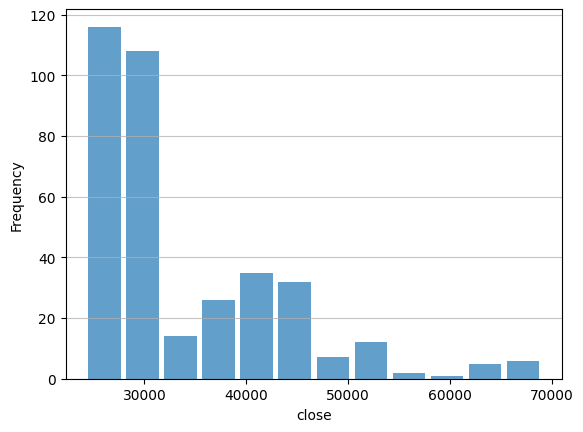

In [57]:
n, bins, patches = plt.hist(x=bitcoin['close'], bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('close')
plt.ylabel('Frequency')

In [7]:
from scipy import stats
def ignore_nans(a, b):
    index = ~a.isnull() & ~b.isnull()
    return a[index], b[index]
stats.pearsonr(*ignore_nans(bitcoin['close'], bitcoin['marketCap']))

PearsonRResult(statistic=0.9995982765006826, pvalue=0.0)

c:\Users\Asus\anaconda3\lib\site-packages\dython\nominal.py:736: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
c:\Users\Asus\anaconda3\lib\site-packages\dython\nominal.py:737: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)


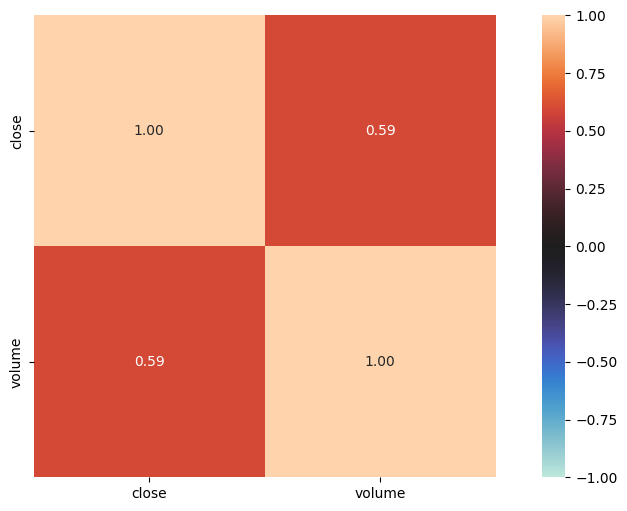

{'corr':            close    volume
 close   1.000000  0.594508
 volume  0.594508  1.000000,
 'ax': <Axes: >}

In [56]:
import dython
dython.nominal.associations(bitcoin[['close', 'volume']], figsize=(12, 6))

Text(37.722222222222214, 0.5, 'marketCap')

<Figure size 1200x600 with 0 Axes>

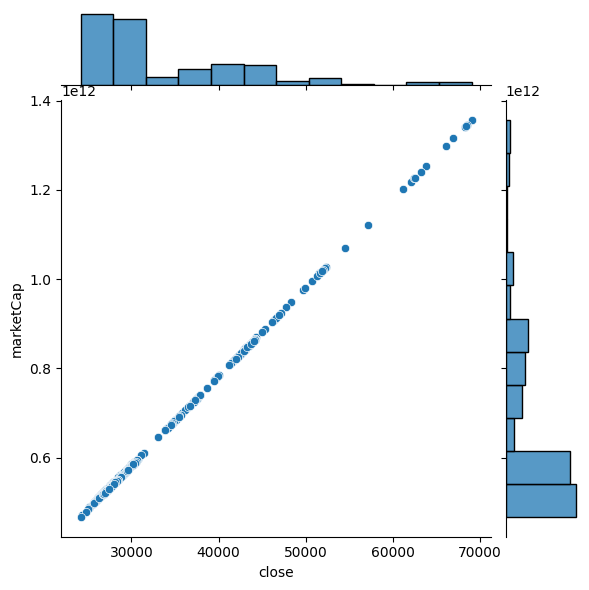

In [58]:
plt.figure(figsize=(12, 6))
sns.jointplot(x="close", y="marketCap", edgecolor="white", data=bitcoin)
plt.xlabel("close")
plt.ylabel("marketCap")

In [4]:
bitcoin = bitcoin[['timestamp', 'close']]
bitcoin['timestamp'] = pd.to_datetime(bitcoin['timestamp'])
bitcoin.set_index('timestamp', inplace=True)

In [52]:
from numpy import polyfit

def fit(X, y, degree=3):
    coef = polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)
def get_season(s, yearly_periods=4, degree=3):
    X = [i%(365/yearly_periods) for i in range(0, len(s))]
    seasonal = fit(X, s.values, degree)
    return pd.Series(data=seasonal, index=s.index)
def get_trend(s, degree=3):
    X = list(range(len(s)))
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)

Text(0, 0.5, 'Temperature change')

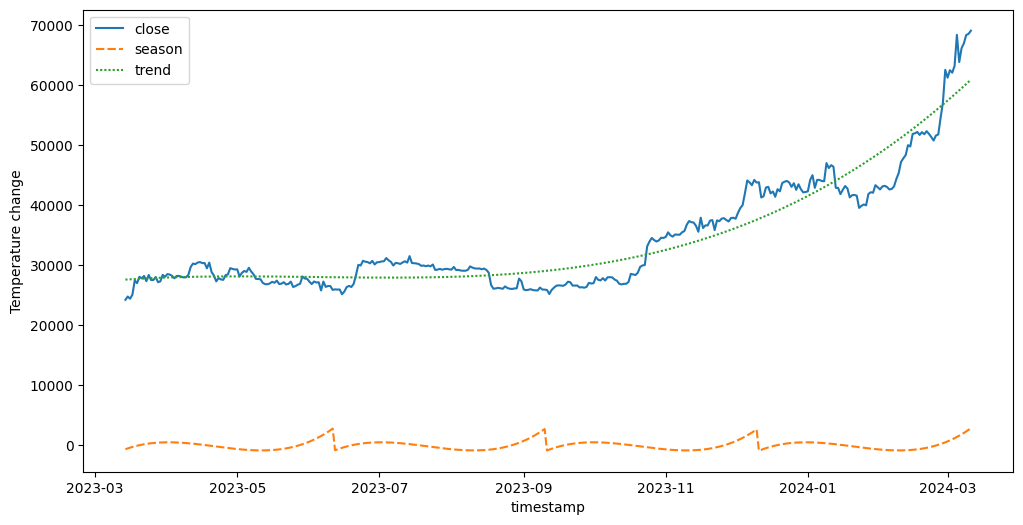

In [53]:
plt.figure(figsize=(12, 6))
bitcoin['trend'] = get_trend(bitcoin['close'])
bitcoin['season'] = get_season(bitcoin['close'] - bitcoin['trend'])
sns.lineplot(data=bitcoin[['close', 'season', 'trend']])
plt.ylabel('Temperature change')

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

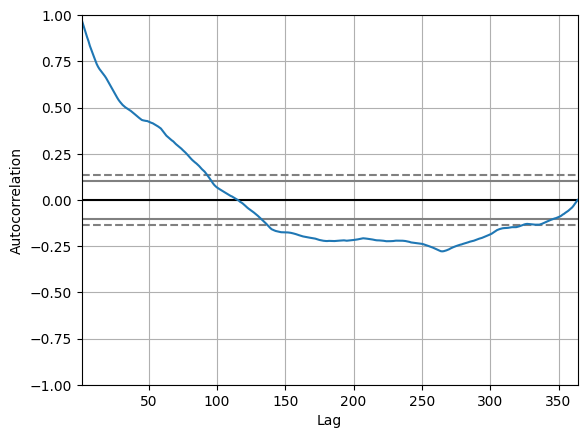

In [5]:
pd.plotting.autocorrelation_plot(bitcoin['close'])

In [6]:
from statsmodels.tsa import stattools
stattools.adfuller(bitcoin['close'])

(-4.6096364396667395,
 0.00012398874616338854,
 2,
 361,
 {'1%': -3.4485948978753314,
  '5%': -2.86957971128312,
  '10%': -2.571053050314224},
 5551.7056345239325)

**=========================================================================================================================**
**=========================================================================================================================**
**=========================================================================================================================**
**=========================================================================================================================**

## Naive Prediction or Baseline Models ##

Implementing the historical mean baseline

In [45]:
print(len(bitcoin))
train = bitcoin[:-30]
test = bitcoin[-30:]
print(len(train))
print(len(test))

364
334
30


In [46]:
historical_mean = np.mean(train['close']) 
print(historical_mean)

32078.644465130743


In [48]:
test.loc[:, 'pred_mean'] = historical_mean

Mean Absolute Percentage Error (MAPE)

In [49]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_hist_mean = mape(test['close'], test['pred_mean'])
print(mape_hist_mean)

42.90579641835103


In [50]:
bitcoin.tail()

timeOpen                 timeClose  \
359  2024-03-06T00:00:00.000Z  2024-03-06T23:59:59.999Z   
360  2024-03-07T00:00:00.000Z  2024-03-07T23:59:59.999Z   
361  2024-03-08T00:00:00.000Z  2024-03-08T23:59:59.999Z   
362  2024-03-09T00:00:00.000Z  2024-03-09T23:59:59.999Z   
363  2024-03-10T00:00:00.000Z  2024-03-10T23:59:59.999Z   

                     timeHigh                   timeLow  name          open  \
359  2024-03-06T08:35:00.000Z  2024-03-06T03:00:00.000Z  2781  63776.051426   
360  2024-03-07T17:26:00.000Z  2024-03-07T01:11:00.000Z  2781  66099.741652   
361  2024-03-08T15:32:00.000Z  2024-03-08T16:13:00.000Z  2781  66938.093485   
362  2024-03-09T07:12:00.000Z  2024-03-09T02:02:00.000Z  2781  68299.259726   
363  2024-03-10T10:22:00.000Z  2024-03-10T22:58:00.000Z  2781  68500.255854   

             high           low         close        volume     marketCap  \
359  67637.929859  62848.671519  66106.802787  6.875023e+10  1.298635e+12   
360  68029.918692  65655.534200  66925.483202  4.698954e+10  1.315182e+12   
361  70083.051624  66230.452140  68300.095691  5.920288e+10  1.341993e+12   
362  68673.058034  68053.125219  68498.881304  2.160965e+10  1.346015e+12   
363  70005.199901  68239.980387  69019.786364  3.568398e+10  1.356284e+12   

                    timestamp  
359  2024-03-06T23:59:59.999Z  
360  2024-03-07T23:59:59.999Z  
361  2024-03-08T23:59:59.999Z  
362  2024-03-09T23:59:59.999Z  
363  2024-03-10T23:59:59.999Z

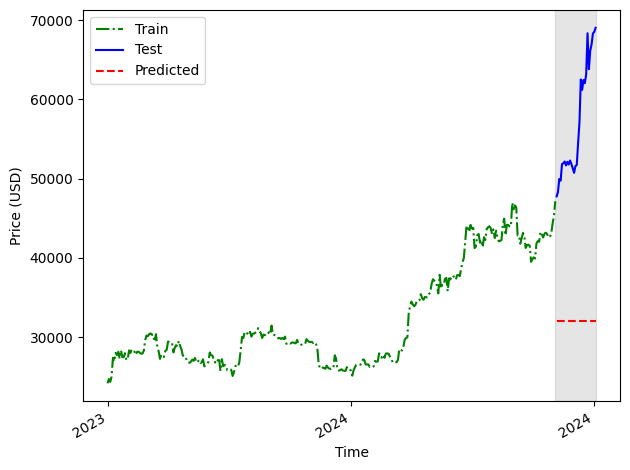

In [51]:
fig, ax = plt.subplots()
ax.plot(train['timestamp'], train['close'], 'g-.', label='Train')
ax.plot(test['timestamp'], test['close'], 'b-', label='Test')
ax.plot(test['timestamp'], test['pred_mean'], 'r--', label='Predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Price (USD)')
ax.axvspan(333, 363, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 363, 181), [2023, 2024, 2024])
fig.autofmt_xdate()
plt.tight_layout()

Predicting using the last known value

In [35]:
last1 = train[-1:]['close']
print(last1)
last2 = train['close'].iloc[-1]
print(last2)
last3 = train['close'][-1:].values
print(last3)
last = train.close.iloc[-1]
print(last)

333    47147.200313
Name: close, dtype: float64
47147.2003126111
[47147.20031261]
47147.2003126111


In [20]:
test.loc[:, 'pred_last'] = last
mape_last = mape(test['close'], test['pred_last'])
print(mape_last)

16.08648377025394


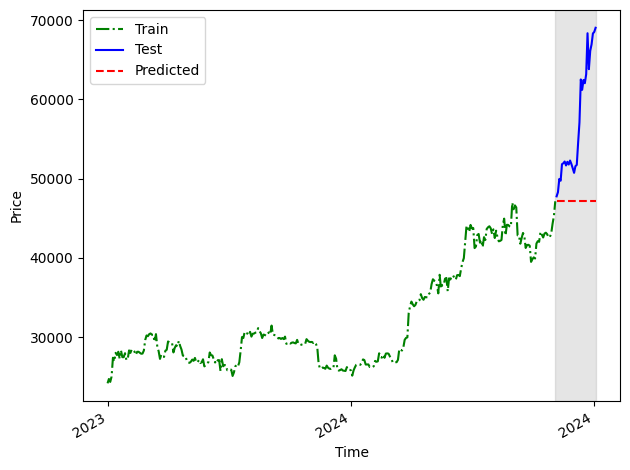

In [29]:
fig, ax = plt.subplots()
ax.plot(train['timestamp'], train['close'], 'g-.', label='Train')
ax.plot(test['timestamp'], test['close'], 'b-', label='Test')
ax.plot(test['timestamp'], test['pred_last'], 'r--', label='Predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.axvspan(333, 363, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 363, 181), [2023, 2024, 2024])
fig.autofmt_xdate()
plt.tight_layout()

Simulating a random walk process

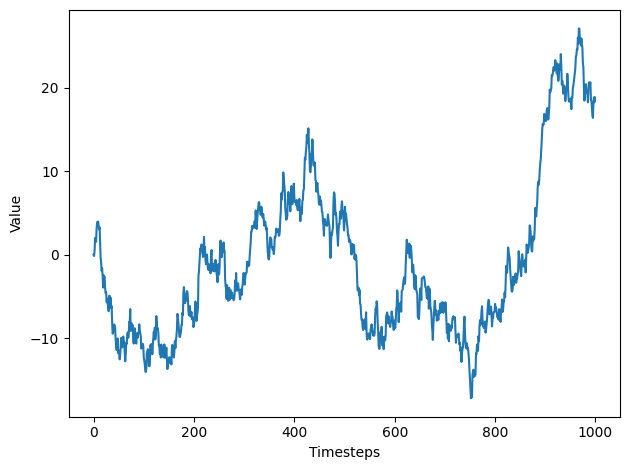

In [7]:
np.random.seed(42)
steps = np.random.standard_normal(1000)
steps[0]=0
random_walk = np.cumsum(steps)
fig, ax = plt.subplots()
ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
plt.tight_layout()

Test for stationarity and plot ACF function

ADF Statistic: 2.710304802127979
p-value: 0.9990874934519166


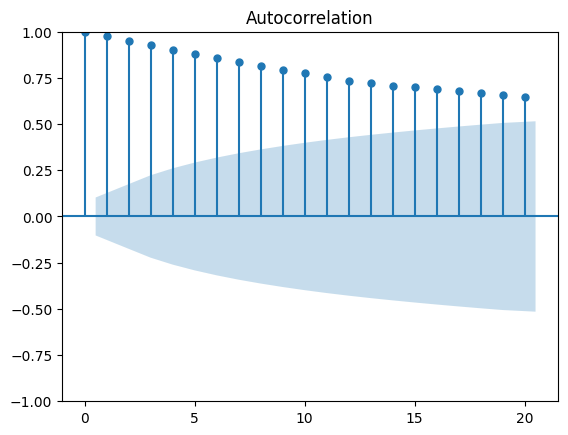

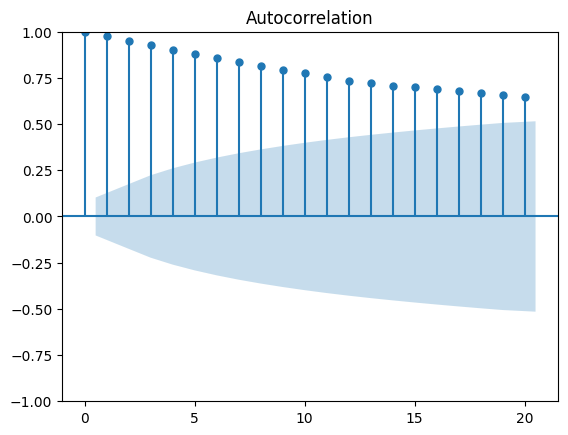

In [12]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

ADF_result = adfuller(bitcoin['close'].values)
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

plot_acf(bitcoin['close'].values, lags=20)

bitcoin time series data is autocorrelated and not stationary.

Apply a first-order differencing to make it stationary in order to retrieve useful information from the ACF plot.

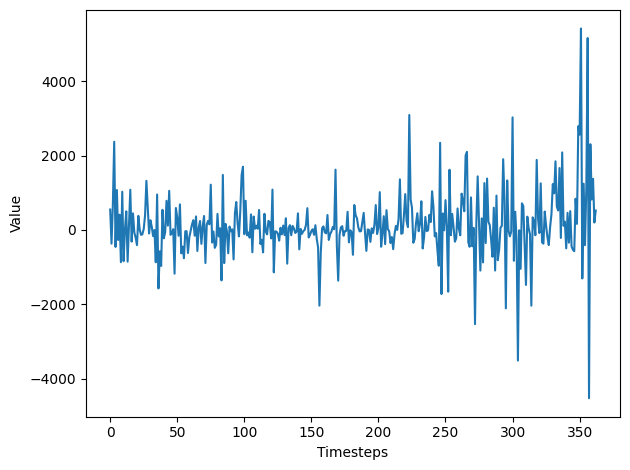

In [22]:
diff_bitcoin = np.diff(bitcoin['close'].values, n=1)
fig, ax = plt.subplots()
ax.plot(diff_bitcoin)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
plt.tight_layout()

Test for stationarity and plot ACF function again.

ADF Statistic: -12.320910129203334
p-value: 6.754467770365742e-23


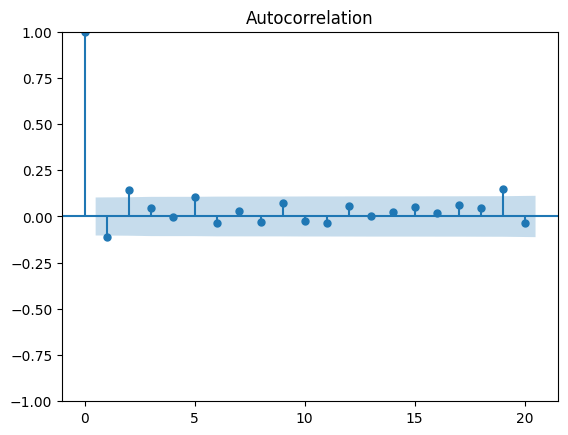

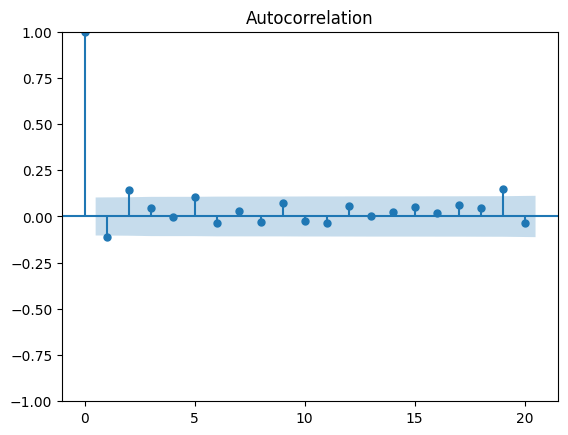

In [23]:
ADF_result = adfuller(diff_bitcoin) 
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
plot_acf(diff_bitcoin, lags=20)

Transformed bitcoin time series data is correlated and stationary. So we have a stationary moving average process of order 2.

## Forecasting a random walk ##

Forecasting on a long horizon

Drift Baseline Model

In [3]:
train = bitcoin[:-30]
test = bitcoin[-30:]

In [11]:
last_value = train['close'][-1:].values
first_value = train['close'][:1].values
deltaX = 334 - 1
deltaY = last_value - first_value
train.tail()

timeOpen                 timeClose  \
329  2024-02-05T00:00:00.000Z  2024-02-05T23:59:59.999Z   
330  2024-02-06T00:00:00.000Z  2024-02-06T23:59:59.999Z   
331  2024-02-07T00:00:00.000Z  2024-02-07T23:59:59.999Z   
332  2024-02-08T00:00:00.000Z  2024-02-08T23:59:59.999Z   
333  2024-02-09T00:00:00.000Z  2024-02-09T23:59:59.999Z   

                     timeHigh                   timeLow  name          open  \
329  2024-02-05T13:38:00.000Z  2024-02-05T01:14:00.000Z  2781  42577.622981   
330  2024-02-06T16:31:00.000Z  2024-02-06T01:05:00.000Z  2781  42657.391074   
331  2024-02-07T21:32:00.000Z  2024-02-07T03:59:00.000Z  2781  43090.021297   
332  2024-02-08T20:18:00.000Z  2024-02-08T00:00:00.000Z  2781  44332.125602   
333  2024-02-09T18:25:00.000Z  2024-02-09T00:50:00.000Z  2781  45297.384253   

             high           low         close        volume     marketCap  \
329  43494.248632  42264.817297  42658.666048  1.871549e+10  8.369361e+11   
330  43344.148218  42529.021423  43084.671864  1.679848e+10  8.453385e+11   
331  44341.948333  42775.958471  44318.224451  2.112659e+10  8.695853e+11   
332  45575.841721  44332.125602  45301.566629  2.615452e+10  8.889215e+11   
333  48152.494628  45260.824572  47147.200313  3.931677e+10  9.251845e+11   

                    timestamp  
329  2024-02-05T23:59:59.999Z  
330  2024-02-06T23:59:59.999Z  
331  2024-02-07T23:59:59.999Z  
332  2024-02-08T23:59:59.999Z  
333  2024-02-09T23:59:59.999Z

Calculate the drift:

In [16]:
drift = deltaY / deltaX
print(drift)
x_vals = np.arange(334, 364, 1)
pred_drift = drift * x_vals + first_value
test.loc[:, 'pred_drift'] = pred_drift
test.head()

[68.91791986]


timeOpen                 timeClose  \
334  2024-02-10T00:00:00.000Z  2024-02-10T23:59:59.999Z   
335  2024-02-11T00:00:00.000Z  2024-02-11T23:59:59.999Z   
336  2024-02-12T00:00:00.000Z  2024-02-12T23:59:59.999Z   
337  2024-02-13T00:00:00.000Z  2024-02-13T23:59:59.999Z   
338  2024-02-14T00:00:00.000Z  2024-02-14T23:59:59.999Z   

                     timeHigh                   timeLow  name          open  \
334  2024-02-10T20:48:00.000Z  2024-02-10T10:54:00.000Z  2781  47153.528425   
335  2024-02-11T04:01:00.000Z  2024-02-11T01:29:00.000Z  2781  47768.968130   
336  2024-02-12T21:15:00.000Z  2024-02-12T10:08:00.000Z  2781  48296.385196   
337  2024-02-13T01:37:00.000Z  2024-02-13T17:13:00.000Z  2781  49941.361162   
338  2024-02-14T14:38:00.000Z  2024-02-14T04:37:00.000Z  2781  49733.444799   

             high           low         close        volume     marketCap  \
334  48146.170431  46905.321686  47771.277367  1.639868e+10  9.374767e+11   
335  48535.935910  47617.405365  48293.916751  1.931587e+10  9.477742e+11   
336  50280.475274  47745.760261  49958.224219  3.451199e+10  9.804910e+11   
337  50358.392086  48406.495564  49742.440990  3.559305e+10  9.762999e+11   
338  52021.370779  49296.830923  51826.695996  3.910561e+10  1.017254e+12   

                    timestamp    pred_drift  
334  2024-02-10T23:59:59.999Z  47216.118232  
335  2024-02-11T23:59:59.999Z  47285.036152  
336  2024-02-12T23:59:59.999Z  47353.954072  
337  2024-02-13T23:59:59.999Z  47422.871992  
338  2024-02-14T23:59:59.999Z  47491.789912

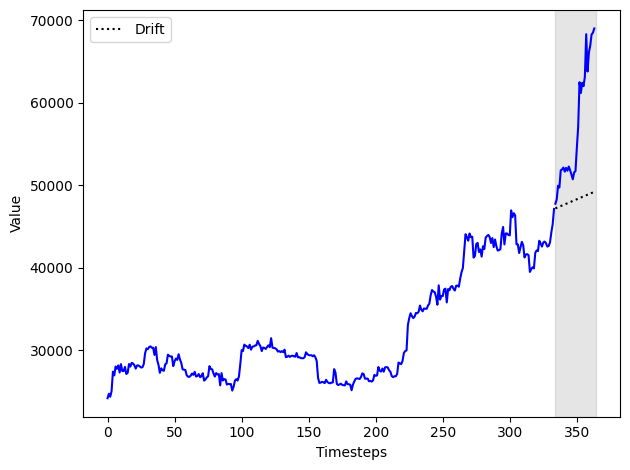

In [23]:
fig, ax = plt.subplots()
ax.plot(train['close'], 'b-')
ax.plot(test['close'], 'b-')
ax.plot(test['pred_drift'], 'k:', label='Drift')
ax.axvspan(334, 364, color='#808080', alpha=0.2)
ax.legend(loc=2)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
plt.tight_layout()

In [24]:
from sklearn.metrics import mean_squared_error
mse_drift = mean_squared_error(test['close'], test['pred_drift'])
print(mse_drift)

120156287.10122515


## Forecasting the moving average process ##

In [3]:
diff_bitcoin = np.diff(bitcoin['close'].values, n=1)
df_diff = pd.DataFrame({'diff_bitcoin': diff_bitcoin})
train = df_diff[:-30]
test = df_diff[-30:]
print(len(train))
print(len(test))

333
30


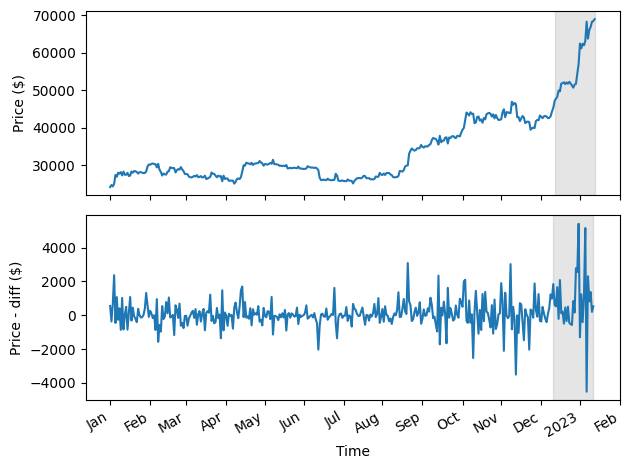

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(bitcoin['close'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Price ($)')
ax1.axvspan(333, 363, color='#808080', alpha=0.2)

ax2.plot(df_diff['diff_bitcoin'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Price - diff ($)')
ax2.axvspan(332, 362, color='#808080', alpha=0.2)

plt.xticks([0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2023', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

A function for rolling forecasts on a horizon

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA    

In [55]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

diff_bitcoin  pred_mean  pred_last_value     pred_MA
333    624.077054  68.917920      1845.633684  -66.164000
334    522.639383  68.917920      1845.633684  154.096824
335   1664.307468  71.929504       522.639383   29.845386
336   -215.783229  71.929504       522.639383   37.520868
337   2084.255006  75.800914      -215.783229  169.870310

In [56]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['diff_bitcoin'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['diff_bitcoin'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['diff_bitcoin'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

3679218.550366001 6631811.723600163 3657607.1642355025


In [57]:
bitcoin['pred_price'] = pd.Series()
bitcoin['pred_price'][334:] = bitcoin['close'].iloc[333] + pred_df['pred_MA'].cumsum()

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_10064\2233923135.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  bitcoin['pred_price'][334:] = bitcoin['close'].iloc[333] + pred_df['pred_MA'].cumsum()
C:\Users\baloochyb\AppData\Local\Temp

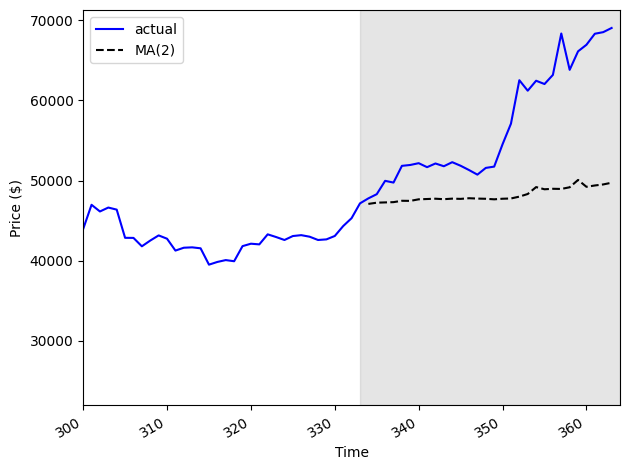

In [58]:
fig, ax = plt.subplots()

ax.plot(bitcoin['close'], 'b-', label='actual') 
ax.plot(bitcoin['pred_price'], 'k--', label='MA(2)') 
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Price ($)')
ax.axvspan(333, 364, color='#808080', alpha=0.2)
ax.set_xlim(300, 364)
fig.autofmt_xdate()
plt.tight_layout()

In [62]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(bitcoin['close'].iloc[334:], bitcoin['pred_price'].iloc[334:])
print(mae_MA_undiff)

8829.476831050439


Partial Autocorrelation Function (PACF)

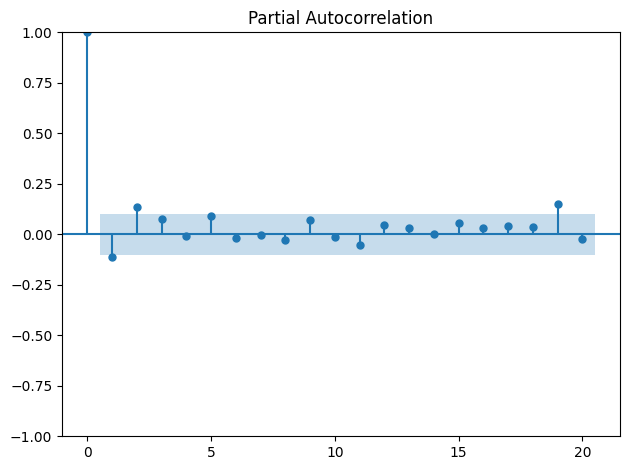

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(diff_bitcoin, lags=20)
plt.tight_layout()

Forecasting an autoregressive process

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    end_idx = train_len
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method == 'AR':
        pred_AR = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
        return pred_AR

In [66]:
TRAIN_LEN = len(train) 
HORIZON = len(test) 
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean 
test['pred_last_value'] = pred_last_value 
test['pred_AR'] = pred_AR

test.head()

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_12688\3337110254.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_mean'] = pred_mean
C:\Users\baloochyb\AppData\Local\Temp\ipykernel_12688\3337110254.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_last_value'] = pred_last_value
C:\Users\baloochyb\AppData\Local\Temp\ipykernel_12688\3337110254.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

diff_bitcoin  pred_mean  pred_last_value     pred_AR
333    624.077054  68.917920      1845.633684  -80.947221
334    522.639383  70.580073       624.077054   81.627063
335   1664.307468  71.929504       522.639383    9.550728
336   -215.783229  76.668724      1664.307468  -64.138049
337   2084.255006  75.800914      -215.783229  143.792642

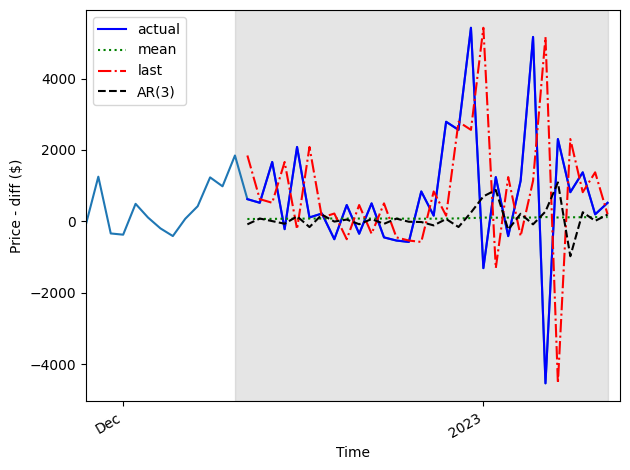

In [67]:
fig, ax = plt.subplots()

ax.plot(df_diff['diff_bitcoin']) 
ax.plot(test['diff_bitcoin'], 'b-', label='actual') 
ax.plot(test['pred_mean'], 'g:', label='mean') 
ax.plot(test['pred_last_value'], 'r-.', label='last') 
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Price - diff ($)')

ax.axvspan(332, 362, color='#808080', alpha=0.2)
ax.set_xlim(320, 363)
plt.xticks([323, 352], ['Dec', '2023'])
fig.autofmt_xdate()
plt.tight_layout()

In [68]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['diff_bitcoin'], test['pred_mean'])
mse_last = mean_squared_error(test['diff_bitcoin'], test['pred_last_value'])
mse_AR = mean_squared_error(test['diff_bitcoin'], test['pred_AR'])
print(mse_mean, mse_last, mse_AR)

3680249.5365142077 8484602.18904163 3761761.570332173


In [69]:
bitcoin['pred_price'] = pd.Series()
bitcoin['pred_price'][334:] = bitcoin['close'].iloc[333] + test['pred_last_value'].cumsum()

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_12688\1686053737.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  bitcoin['pred_price'][334:] = bitcoin['close'].iloc[333] + test['pred_last_value'].cumsum()
C:\Users\baloochyb\AppData\Local

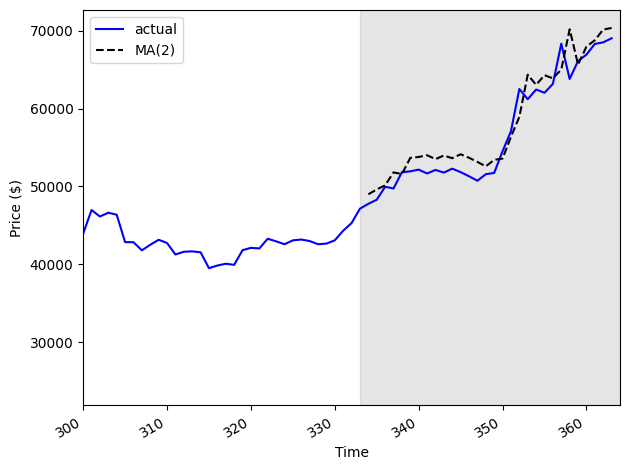

In [70]:
fig, ax = plt.subplots()

ax.plot(bitcoin['close'], 'b-', label='actual') 
ax.plot(bitcoin['pred_price'], 'k--', label='MA(2)') 
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Price ($)')
ax.axvspan(333, 364, color='#808080', alpha=0.2)
ax.set_xlim(300, 364)
fig.autofmt_xdate()
plt.tight_layout()

In [71]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(bitcoin['close'].iloc[334:], bitcoin['pred_price'].iloc[334:])
print(mae_MA_undiff)

1733.2578842177022


In [72]:
winrate = 0
profit = 0
loserate = 0
for i in range(334, 364):
    if bitcoin['pred_price'].iloc[i] > bitcoin['close'].iloc[i - 1]:
        if bitcoin['close'].iloc[i - 1] < bitcoin['close'].iloc[i]:
            winrate = winrate +1
        else:
            loserate = loserate +1
        profit = profit + (bitcoin['close'].iloc[i] - bitcoin['close'].iloc[i - 1])
print(winrate)
print(loserate)
print(profit)

21
9
21872.586051194703


## General modeling procedure for an ARMA(p,q) ##

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

bitcoin = pd.read_csv('Bitcoin2.csv', sep=';')
bitcoin = bitcoin.iloc[::-1].reset_index(drop=True)

In [24]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

ADF_result = adfuller(bitcoin['close'].values)
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.38850644004741347
p-value: 0.912000175776325


In [25]:
diff_bitcoin = np.diff(bitcoin['close'].values, n=1)
df_diff = pd.DataFrame({'diff_bitcoin': diff_bitcoin})
train = df_diff[:-30]
test = df_diff[-30:]
print(len(train))
print(len(test))

333
30


In [26]:
ADF_result = adfuller(diff_bitcoin)
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -3.9772361266985063
p-value: 0.0015345140737444093


Defining a list of possible values for p and q.

In [21]:
from itertools import product

ps = range(0, 9, 1)
qs = range(0, 9, 1)

order_list = list(product(ps, qs))


Function to fit all unique ARMA(p,q) models

In [5]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

"train" is stationary.

In [30]:
result_df = optimize_ARMA(train['diff_bitcoin'], order_list)
result_df

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_1056\3775156193.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/81 [00:00<?, ?it/s]

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA pa

(p,q)          AIC
0   (8, 6)  5629.034579
1   (2, 5)  5629.134541
2   (3, 5)  5630.240953
3   (4, 3)  5630.441935
4   (5, 2)  5630.478939
..     ...          ...
76  (5, 5)  5641.468911
77  (5, 6)  5642.041637
78  (8, 4)  5642.461868
79  (0, 0)  5643.073652
80  (6, 8)  5646.072688

[81 rows x 2 columns]

Residual Analysis

In [39]:
model = SARIMAX(train['diff_bitcoin'], order=(2,0,5), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

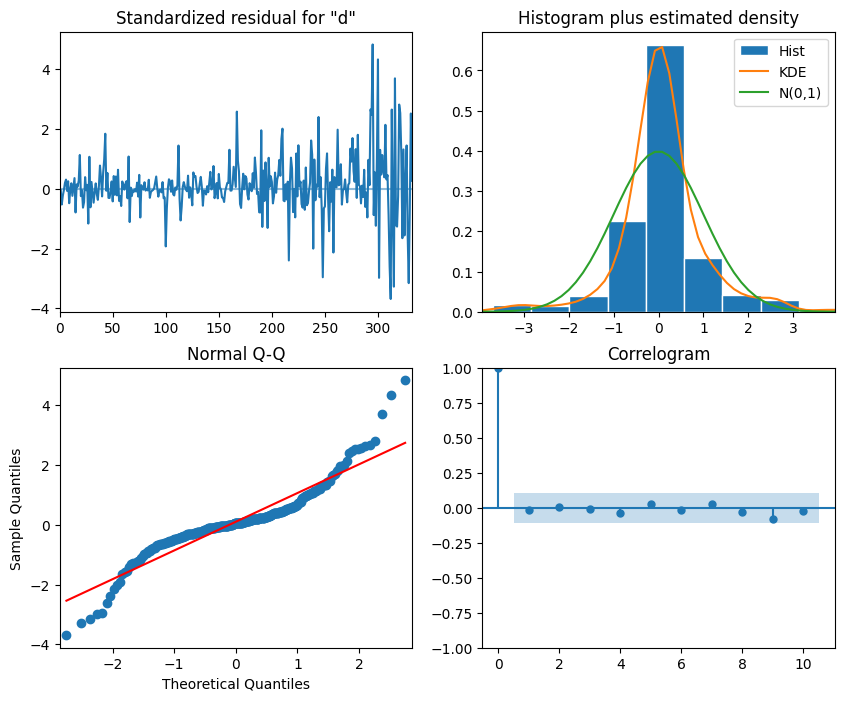

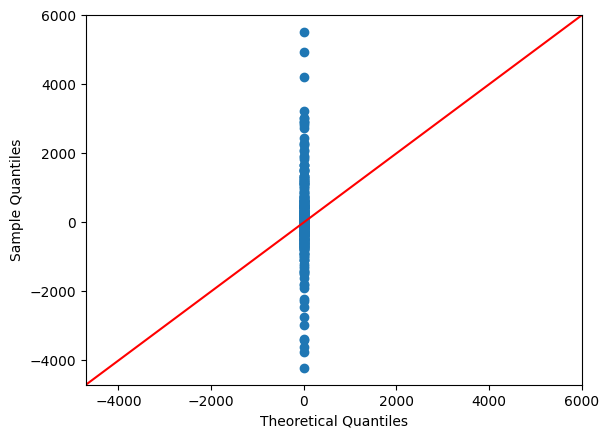

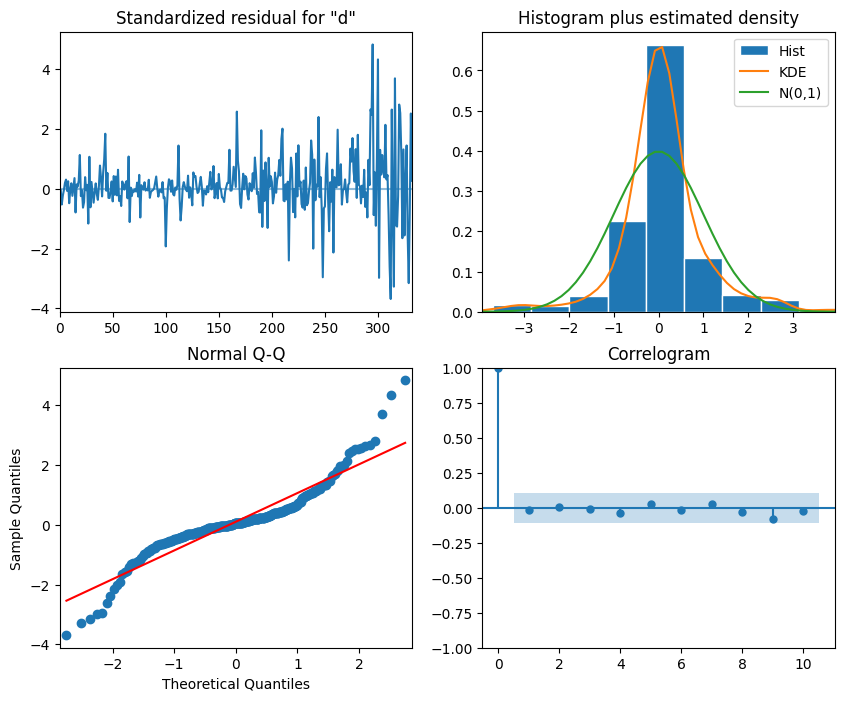

In [40]:
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, line='45')
model_fit.plot_diagnostics(figsize=(10, 8))

In [41]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(residuals, np.arange(1, 11, 1))


lb_stat  lb_pvalue
1   0.113836   0.735818
2   0.123654   0.940046
3   0.167231   0.982697
4   0.576953   0.965590
5   0.761951   0.979396
6   0.828874   0.991277
7   1.011885   0.994635
8   1.365768   0.994719
9   3.546029   0.938679
10  3.754801   0.957731

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    end_idx = train_len
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method == 'ARMA':
        pred_ARMA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,5))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
        return pred_ARMA

In [45]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 5

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_ARMA'] = pred_ARMA

pred_df.head()

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


diff_bitcoin  pred_mean  pred_last_value   pred_ARMA
333   1058.467452  120.55066      -671.199312  -88.321247
334    466.441293  120.55066      -671.199312   -0.904993
335   2268.805669  120.55066      -671.199312  763.137393
336  -2492.341115  120.55066      -671.199312 -543.410398
337   1448.863607  120.55066      -671.199312  278.247113

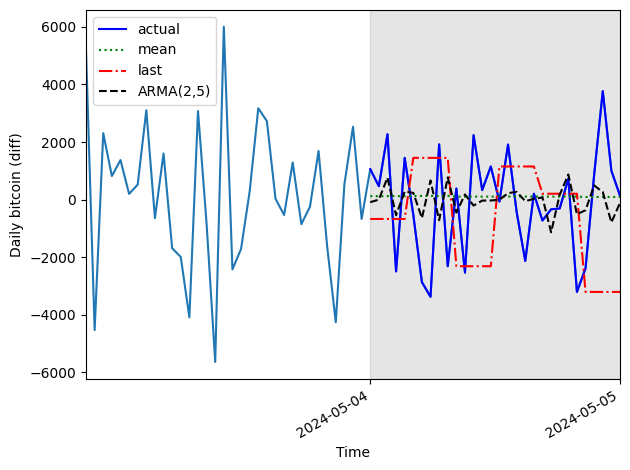

In [54]:
fig, ax = plt.subplots()

ax.plot(df_diff['diff_bitcoin'])
ax.plot(pred_df['diff_bitcoin'], 'b-', label='actual')
ax.plot(pred_df["pred_mean"], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_ARMA'], 'k--', label='ARMA(2,5)')
ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Daily bitcoin (diff)')

ax.axvspan(333, 362, color='#808080', alpha=0.2)
ax.set_xlim(300, 362)
plt.xticks([333, 362], ['2024-05-04', '2024-05-05'])

fig.autofmt_xdate()
plt.tight_layout()

MSE to evaluate the performance

In [56]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['diff_bitcoin'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['diff_bitcoin'], pred_df['pred_last_value'])
mse_ARMA = mean_squared_error(pred_df['diff_bitcoin'], pred_df['pred_ARMA'])
print(mse_mean, mse_last, mse_ARMA)

3325769.430359974 8405267.462717418 3302293.8733085203


Reverse the transformation

In [59]:
bitcoin['pred_bandwidth'] = pd.Series()
bitcoin['pred_bandwidth'][334:] = bitcoin['close'].iloc[334] + pred_df['pred_ARMA'].cumsum()

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_1056\2003357947.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  bitcoin['pred_bandwidth'][334:] = bitcoin['close'].iloc[334] + pred_df['pred_ARMA'].cumsum()
C:\Users\baloochyb\AppData\Local

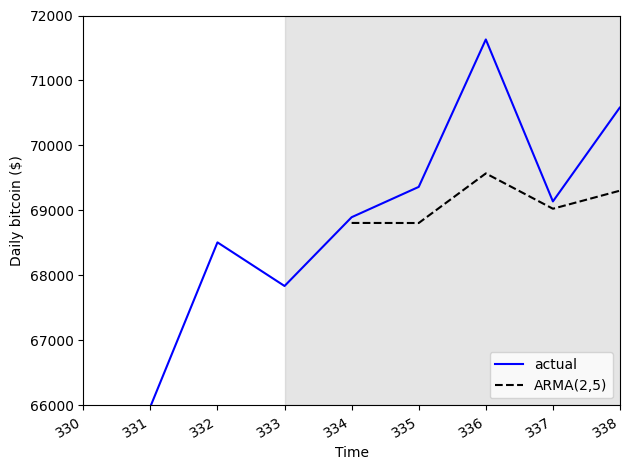

In [69]:
fig, ax = plt.subplots()

ax.plot(bitcoin['close'], 'b-', label='actual')
ax.plot(bitcoin['pred_bandwidth'], 'k--', label='ARMA(2,5)')
ax.legend(loc=4)
ax.set_xlabel('Time')
ax.set_ylabel('Daily bitcoin ($)')
ax.axvspan(333, 363, color='#808080', alpha=0.2)
ax.set_xlim(330, 338)
ax.set_ylim(66000, 72000)
# plt.xticks([333, 363], ['2024-05-04', '2024-05-05'])
fig.autofmt_xdate()
plt.tight_layout()

MAE to evaluate the performance

In [70]:
from sklearn.metrics import mean_absolute_error

mae_ARMA_undiff = mean_absolute_error(bitcoin['close'][334:], bitcoin['pred_bandwidth'][334:])
print(mae_ARMA_undiff)

4551.860150097466


Autoregressive integrated moving average model (ARIIMA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

bitcoin = pd.read_csv('Bitcoin2.csv', sep=';')
bitcoin = bitcoin.iloc[::-1].reset_index(drop=True)

In [2]:
from statsmodels.tsa.stattools import adfuller
eps_diff = np.diff(bitcoin['close'], n=1)
ad_fuller_result = adfuller(eps_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.9772361266985063
p-value: 0.0015345140737444093


In [3]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [4]:
from itertools import product

ps = range(0, 9, 1)
qs = range(0, 9, 1)
d = 1

order_list = list(product(ps, qs))

In [5]:
train = bitcoin.close[:-30]
test = bitcoin.close[-30:]

result_df = optimize_ARIMA(train, order_list, d)
result_df

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_16108\3816043480.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/81 [00:00<?, ?it/s]

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA pa

(p,q)          AIC
0   (2, 1)  5639.467301
1   (2, 5)  5640.497156
2   (4, 3)  5640.526045
3   (1, 3)  5640.625227
4   (5, 2)  5640.764447
..     ...          ...
76  (5, 6)  5651.255600
77  (8, 4)  5653.008819
78  (7, 7)  5654.720235
79  (8, 8)  5656.218135
80  (6, 8)  5657.119811

[81 rows x 2 columns]

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


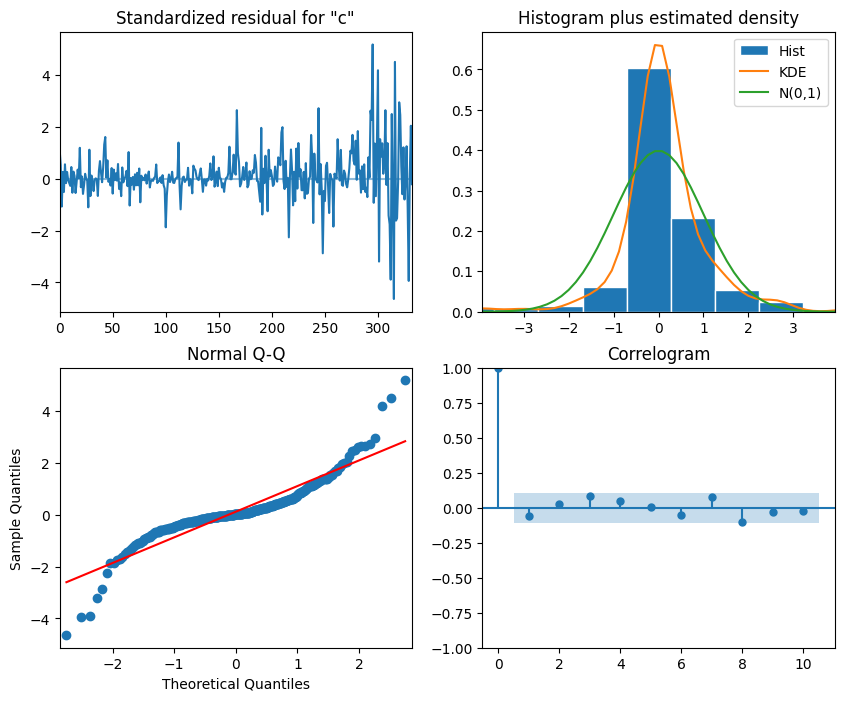

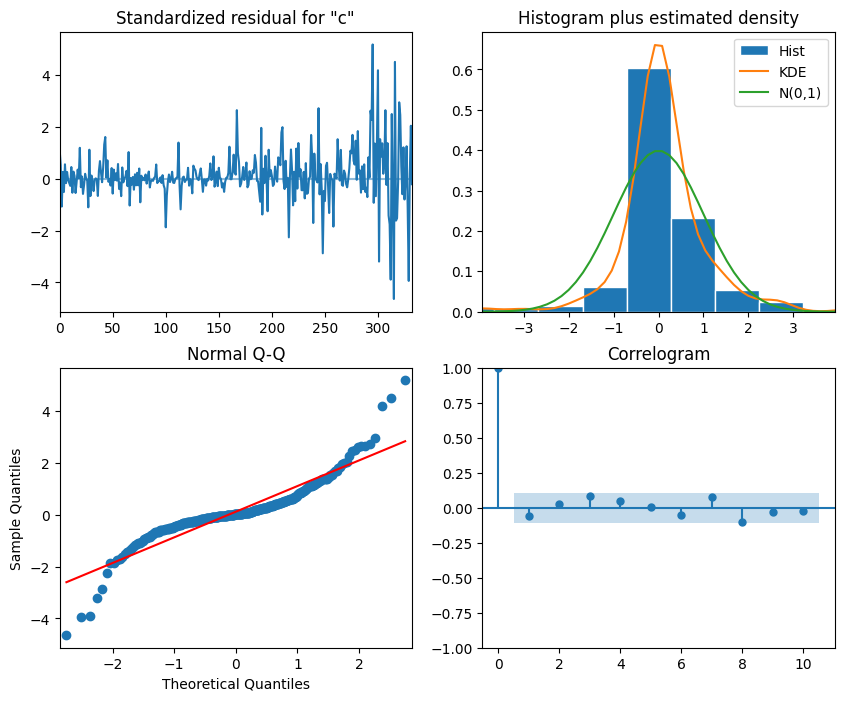

In [11]:
model = SARIMAX(train, order=(2,1,1), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10,8))

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_stat  lb_pvalue
1   0.010442   0.918610
2   0.154652   0.925588
3   0.154693   0.984549
4   0.312142   0.989017
5   0.399653   0.995339
6   0.417541   0.998702
7   0.547809   0.999252
8   0.901541   0.998797
9   0.989364   0.999462
10  1.077550   0.999758

In [99]:
test = bitcoin.iloc[-30:]
test['naive_seasonal'] = bitcoin['close'].iloc[304:334].values

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_16108\3552134467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_seasonal'] = bitcoin['close'].iloc[304:334].values


In [113]:
ARIMA_pred = model_fit.get_prediction(334, 363).predicted_mean
test['ARIMA_pred'] = ARIMA_pred


C:\Users\baloochyb\AppData\Local\Temp\ipykernel_16108\1857721021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


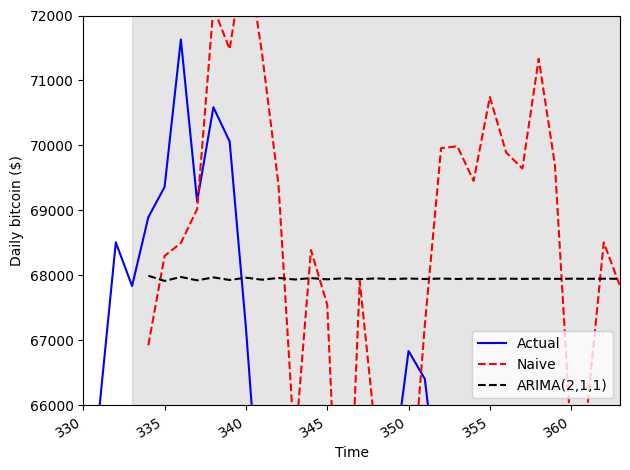

In [115]:
fig, ax = plt.subplots()

ax.plot(bitcoin['close'], 'b-', label='Actual')
ax.plot(test['naive_seasonal'], 'r--', label='Naive')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(2,1,1)')
ax.legend(loc=4)
ax.set_xlabel('Time')
ax.set_ylabel('Daily bitcoin ($)')
ax.axvspan(333, 363, color='#808080', alpha=0.2)
ax.set_xlim(330, 363)
ax.set_ylim(66000, 72000)
# plt.xticks([333, 363], ['2024-05-04', '2024-05-05'])
fig.autofmt_xdate()
plt.tight_layout()

## Seasonal Autoregressive Integrated Moving Average (SARIMA) ##

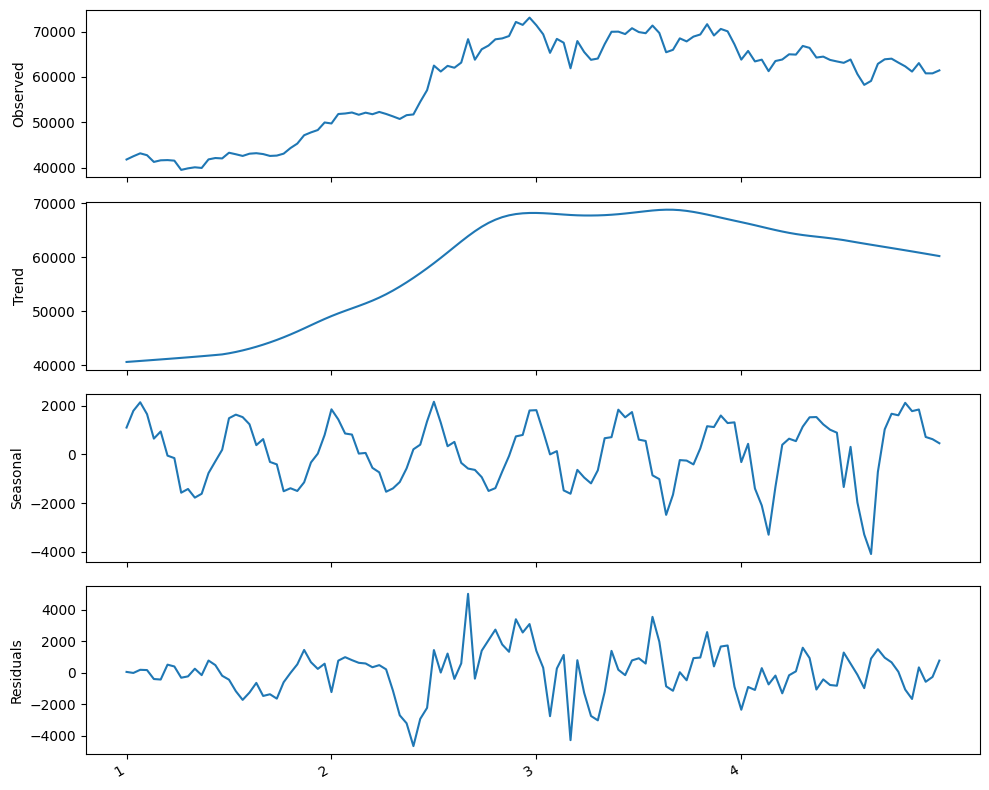

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

bitcoin = pd.read_csv('Bitcoin3.csv', sep=';')
bitcoin = bitcoin.iloc[::-1].reset_index(drop=True)


decomposition = STL(bitcoin['close'], period=15).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
plt.xticks(np.arange(0, 120, 30), np.arange(1, 5, 1))
fig.autofmt_xdate()
plt.tight_layout()

In [50]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(bitcoin['close'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.5426708815699335
p-value: 0.5123070713993901


In [85]:
df_diff = np.diff(bitcoin['close'], n=1) 
ad_fuller_result = adfuller(df_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -12.470595409863598
p-value: 3.251438926278528e-23


In [55]:
from itertools import product

ps = range(0, 16, 1) 
qs = range(0, 16, 1) 
Ps = [0] 
Qs = [0]

d = 1
D = 0
s = 15

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

In [56]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), seasonal_order=(order[2], D, order[3], s), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [57]:
train = bitcoin['close'][:-15]
ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s) 
ARIMA_result_df

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_24864\2428657322.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

(p,q,P,Q)          AIC
0      (0, 0, 0, 0)  1866.932056
1      (1, 0, 0, 0)  1868.640844
2      (0, 1, 0, 0)  1868.643076
3      (2, 0, 0, 0)  1870.431679
4      (0, 2, 0, 0)  1870.435509
..              ...          ...
251  (15, 13, 0, 0)  1906.451521
252  (15, 11, 0, 0)  1907.255820
253  (13, 15, 0, 0)  1907.949965
254  (14, 15, 0, 0)  1908.415565
255  (10, 10, 0, 0)  1925.953738

[256 rows x 2 columns]

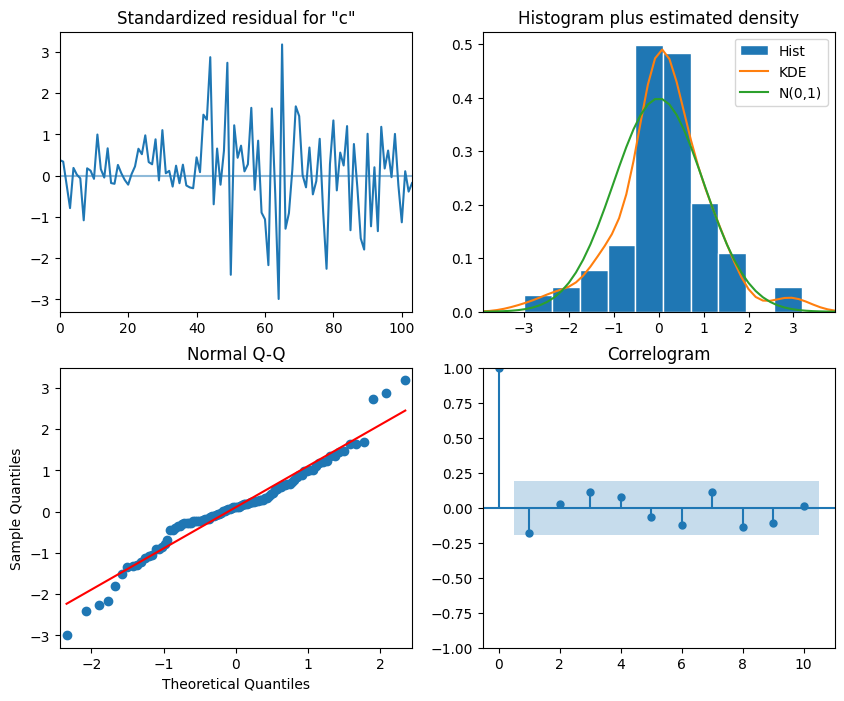

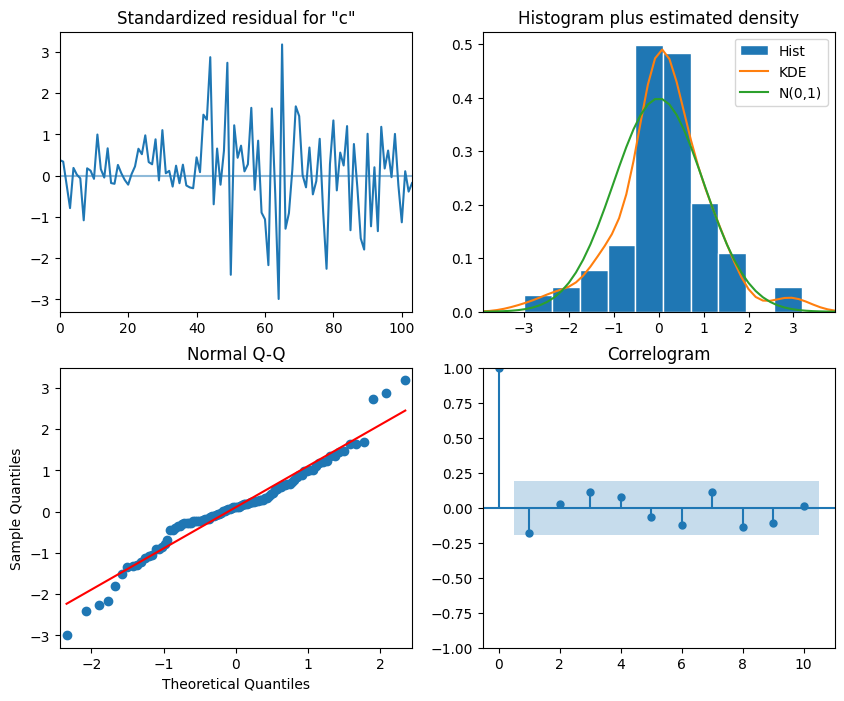

In [58]:
ARIMA_model = SARIMAX(train, order=(0,1,0), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
ARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [60]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = ARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_stat  lb_pvalue
1   0.053735   0.816687
2   0.071072   0.965088
3   0.076045   0.994548
4   0.123991   0.998156
5   0.136209   0.999653
6   0.218413   0.999800
7   0.233558   0.999957
8   0.819883   0.999150
9   0.858916   0.999700
10  0.859095   0.999915

In [81]:
test = bitcoin.iloc[-15:]
test['naive_seasonal'] = bitcoin['close'].iloc[90:105].values
ARIMA_pred = ARIMA_model_fit.get_prediction(105, 120).predicted_mean
test['ARIMA_pred'] = ARIMA_pred

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_24864\312533441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_seasonal'] = bitcoin['close'].iloc[90:105].values
C:\Users\baloochyb\AppData\Local\Temp\ipykernel_24864\312533441.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


SARIMA Application

In [86]:
ps = range(0, 4, 1) 
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)
SARIMA_order_list = list(product(ps, qs, Ps, Qs))
d = 1
D = 0
s = 15

In [87]:
SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s) 
SARIMA_result_df

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_24864\2428657322.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: Us

(p,q,P,Q)          AIC
0    (0, 0, 0, 3)  1865.561946
1    (0, 0, 1, 3)  1866.447571
2    (0, 0, 0, 0)  1866.932056
3    (1, 0, 0, 3)  1867.490080
4    (0, 1, 0, 3)  1867.649959
..            ...          ...
251  (3, 1, 1, 2)  1879.861417
252  (2, 3, 2, 2)  1880.102867
253  (3, 3, 1, 2)  1881.114068
254  (3, 3, 2, 1)  1881.163545
255  (0, 0, 2, 2)  2105.472245

[256 rows x 2 columns]

Model Selected: SARIMA(0,1,0)(0,0,3)15

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


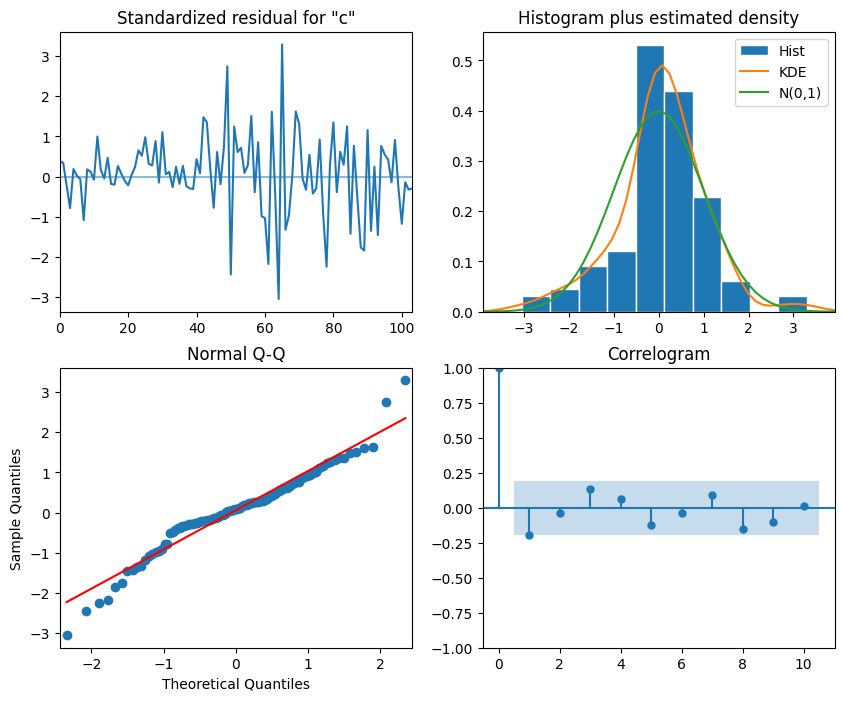

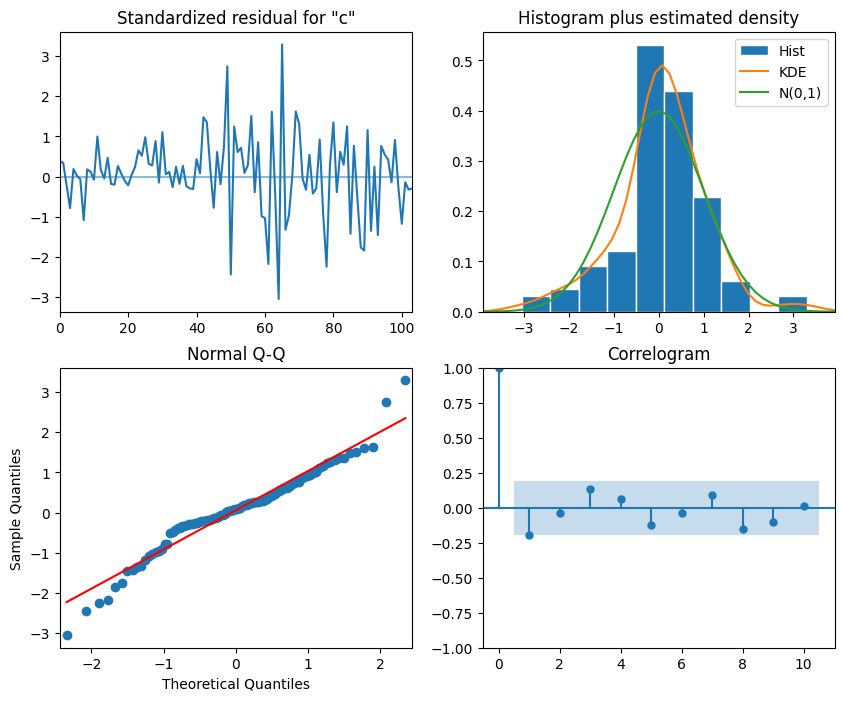

In [88]:
SARIMA_model = SARIMAX(train, order=(0,1,0), seasonal_order=(0,0,3,15), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [89]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_stat  lb_pvalue
1   0.046529   0.829217
2   0.048717   0.975936
3   0.063870   0.995788
4   0.118984   0.998299
5   0.150361   0.999558
6   0.160088   0.999919
7   0.169061   0.999986
8   0.737616   0.999425
9   0.762030   0.999818
10  0.763352   0.999951

In [90]:
SARIMA_pred = SARIMA_model_fit.get_prediction(105, 120).predicted_mean 
test['SARIMA_pred'] = SARIMA_pred

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_24864\2522712433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMA_pred'] = SARIMA_pred


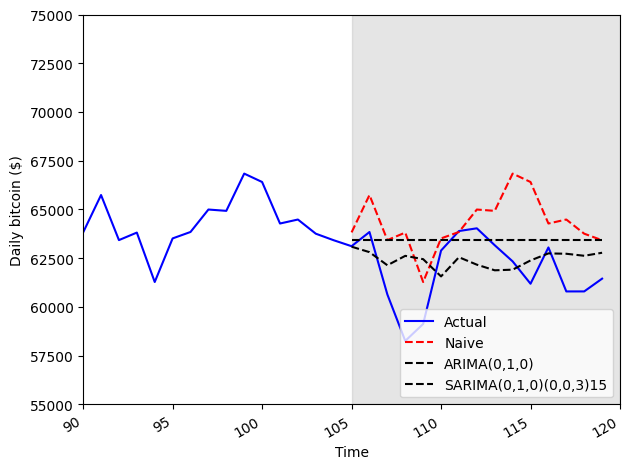

In [91]:
fig, ax = plt.subplots()

ax.plot(bitcoin['close'], 'b-', label='Actual')
ax.plot(test['naive_seasonal'], 'r--', label='Naive')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(0,1,0)')
ax.plot(test['SARIMA_pred'], 'k--', label='SARIMA(0,1,0)(0,0,3)15')
ax.legend(loc=4)
ax.set_xlabel('Time')
ax.set_ylabel('Daily bitcoin ($)')
ax.axvspan(105, 120, color='#808080', alpha=0.2)
ax.set_xlim(90, 120)
ax.set_ylim(55000, 75000)
# plt.xticks([333, 363], ['2024-05-04', '2024-05-05'])
fig.autofmt_xdate()
plt.tight_layout()

## SARIMAX model ##

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

bitcoin = pd.read_csv('Bitcoin2.csv', sep=';')
bitcoin = bitcoin.iloc[::-1].reset_index(drop=True)

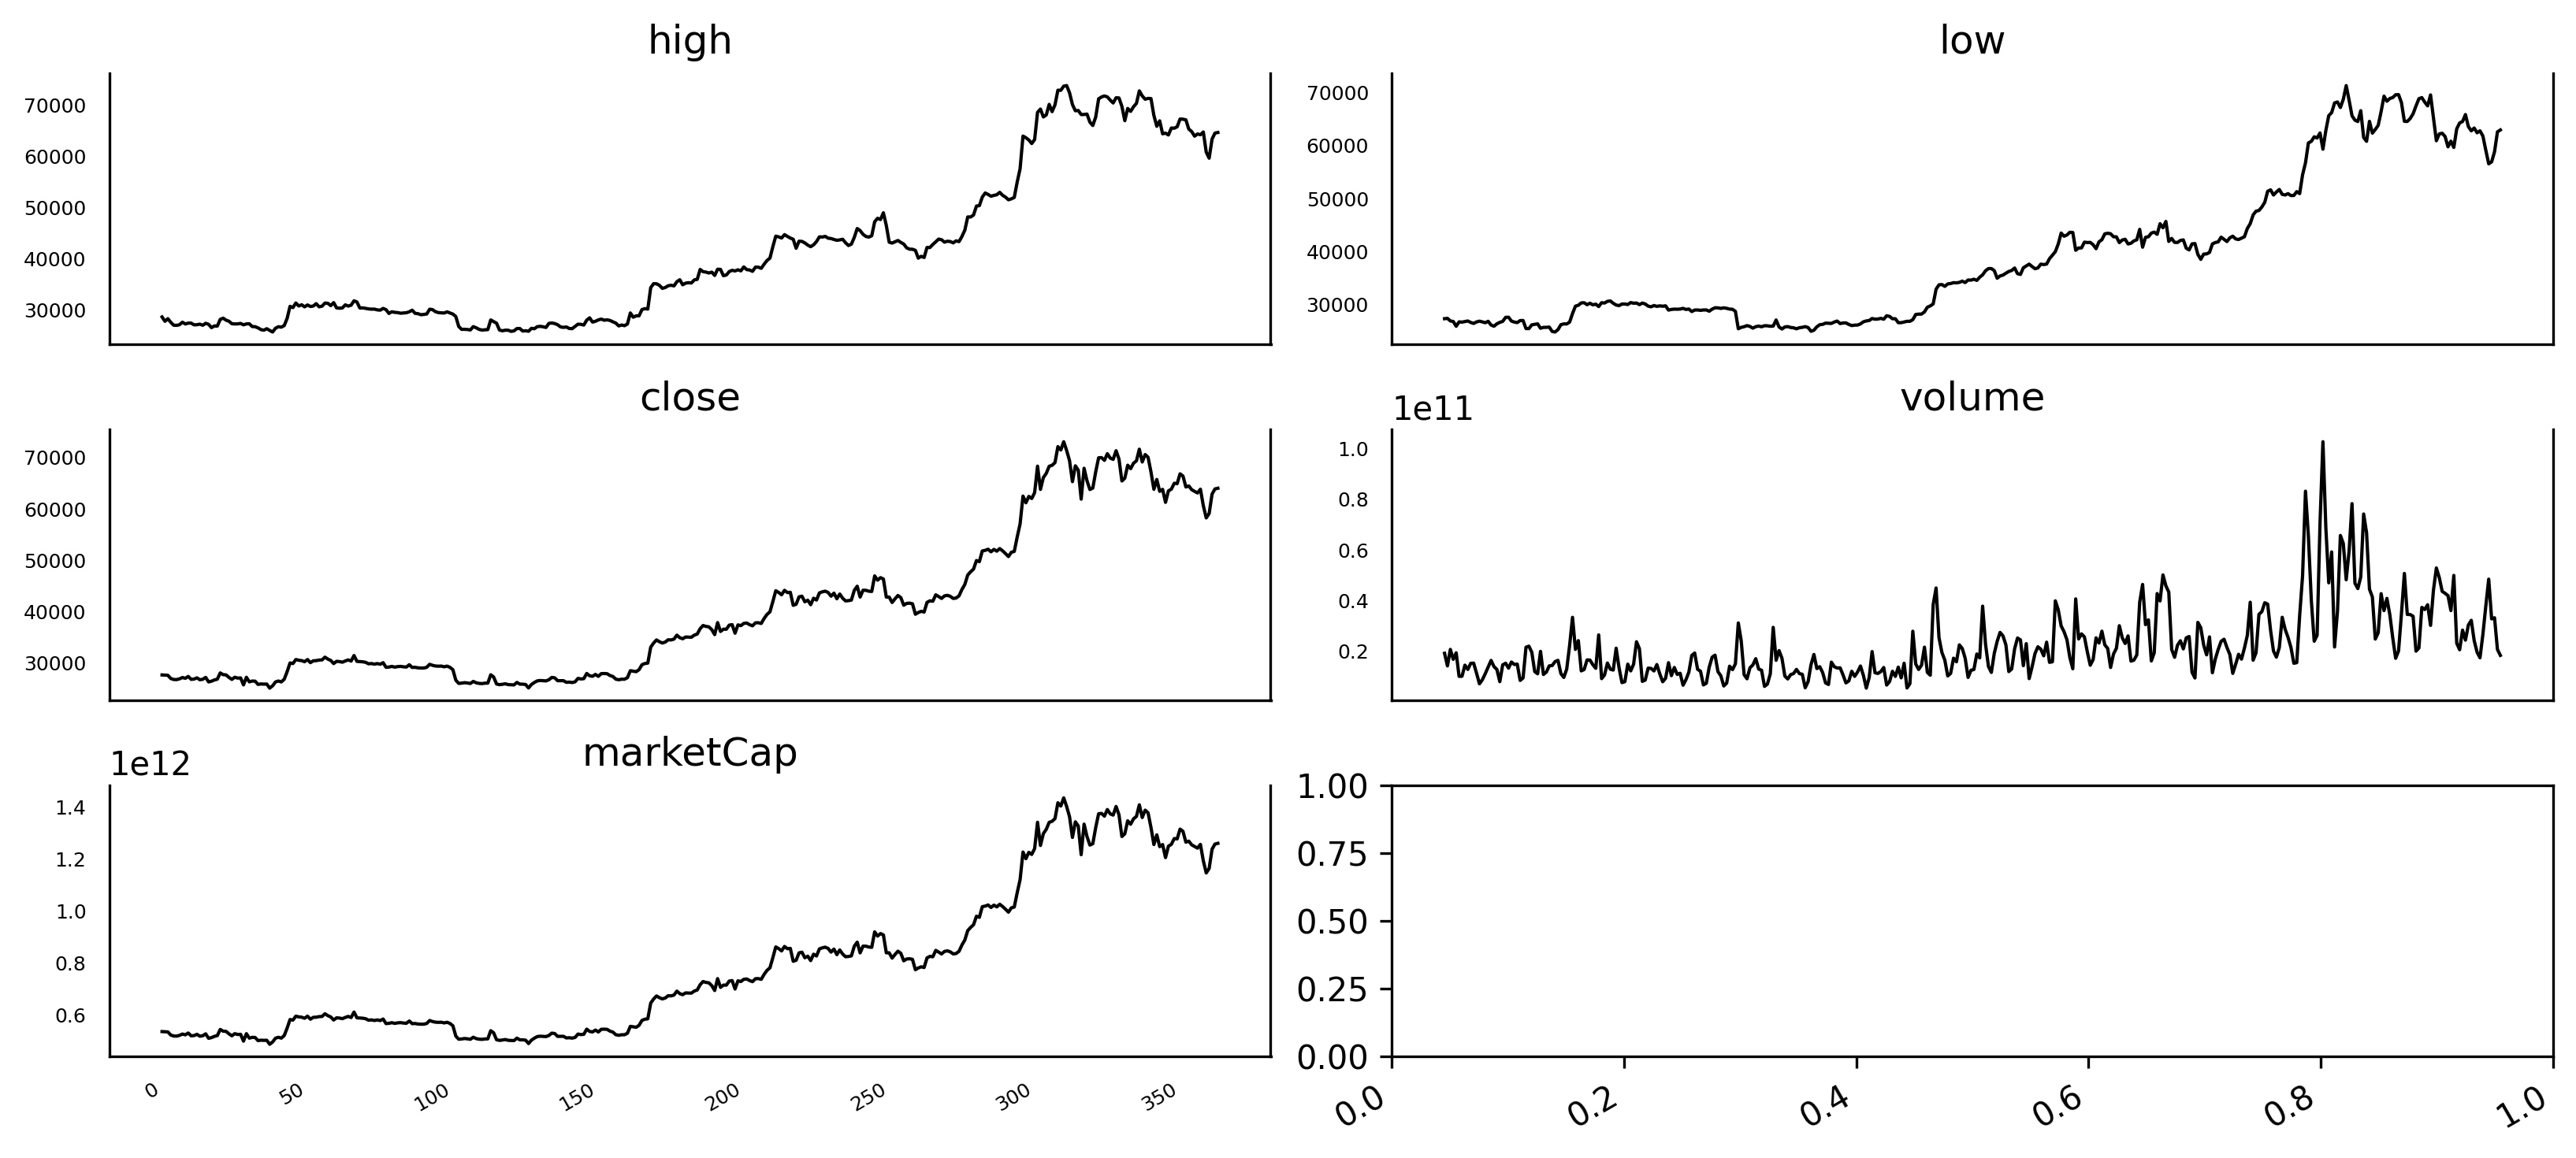

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))
for i, ax in enumerate(axes.flatten()[:5]):
    data = bitcoin[bitcoin.columns[i+6]]
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(bitcoin.columns[i+6]) 
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

fig.autofmt_xdate()
plt.tight_layout()

In [25]:
target = bitcoin['high']
exog = bitcoin[['low', 'close', 'volume', 'marketCap']]

Technical Analysis Indicator (Pandas-TA)

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas_ta\overlap\vwap.py:23: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  vwap  = wp.groupby(wp.index.to_period(anchor)).cumsum()
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas_ta\overlap\vwap.py:24: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  vwap /= volume.groupby(volume.index.to_period(anchor)).cumsum()


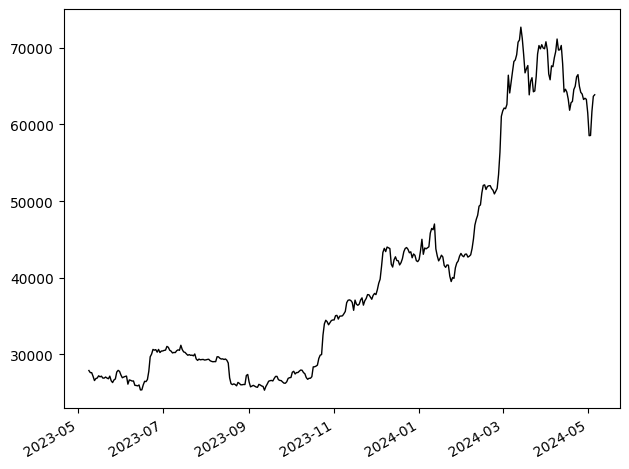

In [46]:
import pandas_ta as ta

atr = ta.atr(low=bitcoin['low'], high=bitcoin['high'], close=bitcoin['close'], length=14)
rsi = ta.rsi(close=bitcoin['close'], length=14)

bitcoin.set_index(pd.DatetimeIndex(bitcoin["timestamp"]), inplace=True)
vwap = ta.vwap(high=bitcoin['high'], low=bitcoin['low'], close=bitcoin['close'], volume=bitcoin['volume'])

fig, ax = plt.subplots()
ax.plot(vwap, color='black', linewidth=1)
fig.autofmt_xdate()
plt.tight_layout()

In [26]:
ad_fuller_result = adfuller(target)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.501701050403143
p-value: 0.8916841202851602


In [27]:
target_diff = target.diff() 
ad_fuller_result = adfuller(target_diff[1:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.9779936522822186
p-value: 0.0015302294085482266


In [28]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, exog, order=(order[0], d, order[1]), seasonal_order=(order[2], D, order[3], s), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [30]:
from itertools import product

p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 30

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [31]:
target_train = target[:-30]
exog_train = exog[:-30]

In [32]:
result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_21600\3733680296.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  war

(p,q,P,Q)          AIC
0    (0, 2, 0, 0)  4953.758214
1    (3, 0, 0, 0)  4953.766127
2    (1, 2, 0, 0)  4955.222518
3    (3, 1, 0, 0)  4955.350427
4    (3, 0, 1, 0)  4955.519091
..            ...          ...
251  (0, 0, 0, 3)  5104.065736
252  (0, 0, 1, 3)  5105.403804
253  (0, 0, 2, 3)  5107.556043
254  (0, 0, 3, 3)  5111.299027
255  (0, 0, 0, 0)  6615.938211

[256 rows x 2 columns]

SARIMAX(0,1,2)(0,0,0)30

In [36]:
best_model = SARIMAX(target_train, exog_train, order=(0,1,2), seasonal_order=(0,0,0,30), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   high   No. Observations:                  334
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -2469.879
Date:                Tue, 14 May 2024   AIC                           4953.758
Time:                        14:24:40   BIC                           4980.415
Sample:                             0   HQIC                          4964.388
                                - 334                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
low            0.4066   5.89e-17    6.9e+15      0.000       0.407       0.407
close          0.4913   3.19e-17   1.54e+16      0.000       0.491       0.491
volume      7.319e-08   1.49e-09     49.019      0.0

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


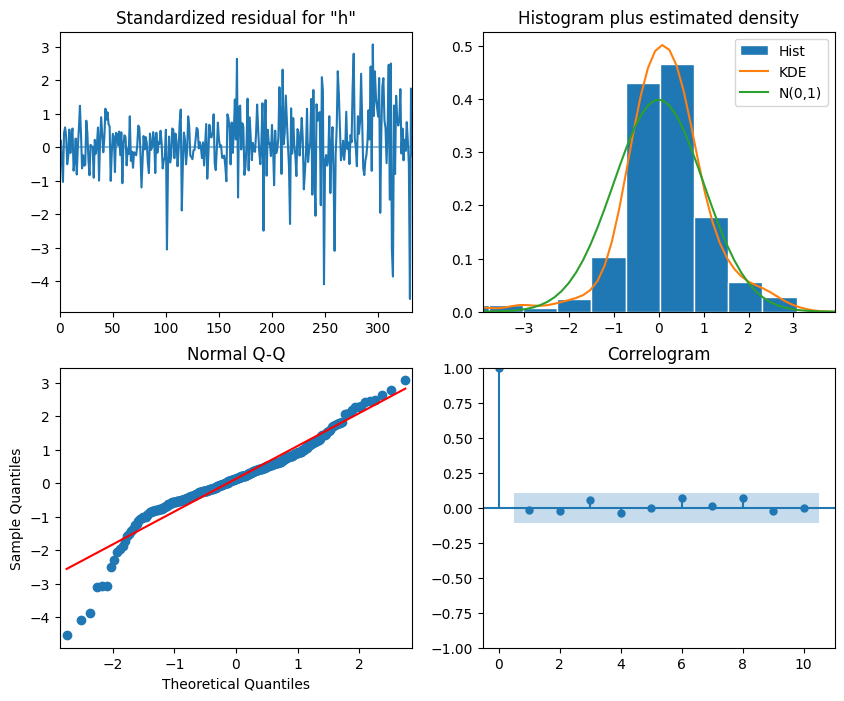

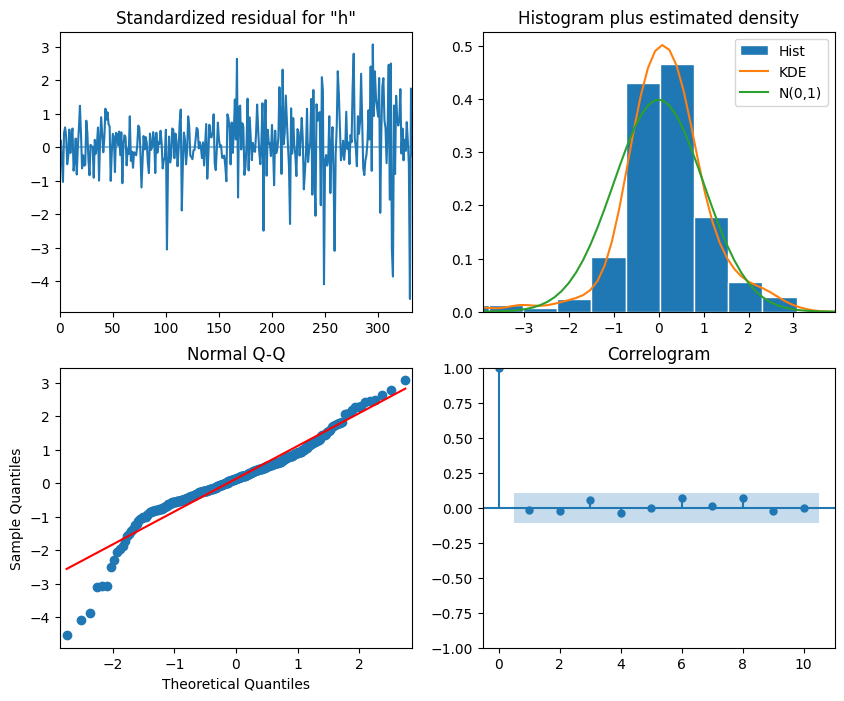

In [37]:
best_model_fit.plot_diagnostics(figsize=(10,8))

In [38]:
residuals = best_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_stat  lb_pvalue
1   0.010686   0.917668
2   0.024605   0.987773
3   0.049322   0.997129
4   0.893395   0.925506
5   0.910134   0.969484
6   1.537421   0.956970
7   1.575322   0.979587
8   1.611020   0.990707
9   1.762322   0.994693
10  1.798639   0.997663

In [45]:
def rolling_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
 
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
 
        return pred_last_value
    elif method == 'SARIMAX':
        pred_SARIMAX = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(0,1,2), seasonal_order=(0,0,0,30), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
        return pred_SARIMAX

In [41]:
target_train = target[:-30]
target_test = target[-30:]

In [43]:
pred_df = pd.DataFrame({'actual': target_test})
TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

In [46]:
pred_last_value = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX
pred_df

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

actual  pred_last_value  pred_SARIMAX
334  69629.602049     68725.758357  68823.456581
335  70284.426265     69629.602049  68771.208071
336  72715.359609     70284.426265  70018.346091
337  71742.506324     72715.359609  72222.319893
338  71093.433161     71742.506324  71446.200942
339  71256.238130     71093.433161  71933.800784
340  71222.742979     71256.238130  71628.350580
341  67931.429364     71222.742979  69792.726804
342  65824.427083     67931.429364  68422.872743
343  66878.646905     65824.427083  69045.012683
344  64355.669263     66878.646905  66237.672008
345  64486.364710     64355.669263  65597.401057
346  64125.686415     64486.364710  63749.828546
347  65481.597054     64125.686415  64372.528516
348  65442.458954     65481.597054  64822.299539
349  65723.239828     65442.458954  64976.415299
350  67233.957036     65723.239828  65609.627731
351  67199.241946     67233.957036  66779.974757
352  67075.369646     67199.241946  67255.461849
353  65275.207518     67075.369646  66397.371654
354  64789.657506     65275.207518  66516.419018
355  63898.361592     64789.657506  65518.383559
356  64321.482808     63898.361592  63938.713061
357  64174.877721     64321.482808  63839.462580
358  64703.332363     64174.877721  64414.911507
359  60780.499677     64703.332363  63897.912936
360  59602.298028     60780.499677  63073.271266
361  63320.503389     59602.298028  60987.745947
362  64494.958426     63320.503389  61495.910949
363  64610.890215     64494.958426  63271.477169

In [47]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

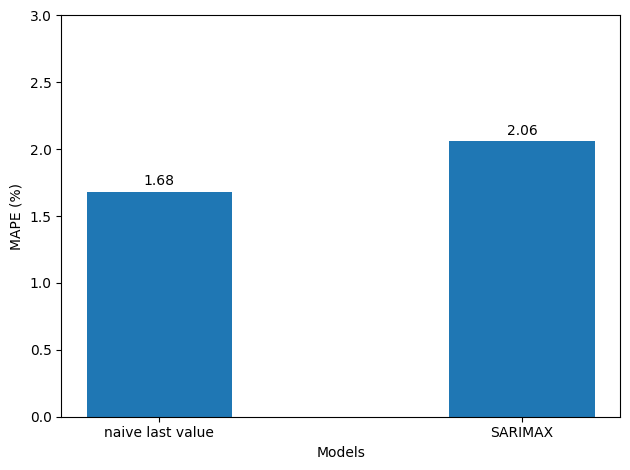

In [60]:
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)
fig, ax = plt.subplots()
x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 3)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
plt.tight_layout()

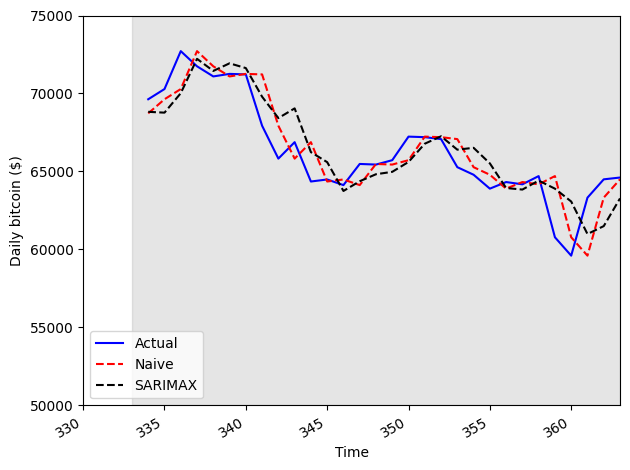

In [65]:
fig, ax = plt.subplots()

ax.plot(pred_df['actual'], 'b-', label='Actual')
ax.plot(pred_df['pred_last_value'], 'r--', label='Naive')
ax.plot(pred_df['pred_SARIMAX'], 'k--', label='SARIMAX')
ax.legend(loc=3)
ax.set_xlabel('Time')
ax.set_ylabel('Daily bitcoin ($)')
ax.axvspan(333, 363, color='#808080', alpha=0.2)
ax.set_xlim(330, 363)
ax.set_ylim(50000, 75000)
# plt.xticks([333, 363], ['2024-05-04', '2024-05-05'])
fig.autofmt_xdate()
plt.tight_layout()

## Vector Autoregression (VAR) ##

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

bitcoin = pd.read_csv('Bitcoin2.csv', sep=';')
bitcoin = bitcoin.iloc[::-1].reset_index(drop=True)
bitcoin

timeOpen                 timeClose  \
0    2023-05-08T00:00:00.000Z  2023-05-08T23:59:59.999Z   
1    2023-05-09T00:00:00.000Z  2023-05-09T23:59:59.999Z   
2    2023-05-10T00:00:00.000Z  2023-05-10T23:59:59.999Z   
3    2023-05-11T00:00:00.000Z  2023-05-11T23:59:59.999Z   
4    2023-05-12T00:00:00.000Z  2023-05-12T23:59:59.999Z   
..                        ...                       ...   
359  2024-05-01T00:00:00.000Z  2024-05-01T23:59:59.999Z   
360  2024-05-02T00:00:00.000Z  2024-05-02T23:59:59.999Z   
361  2024-05-03T00:00:00.000Z  2024-05-03T23:59:59.999Z   
362  2024-05-04T00:00:00.000Z  2024-05-04T23:59:59.999Z   
363  2024-05-05T00:00:00.000Z  2024-05-05T23:59:59.999Z   

                     timeHigh                   timeLow  name          open  \
0    2023-05-08T00:28:00.000Z  2023-05-08T20:11:00.000Z  2781  28450.457478   
1    2023-05-09T12:18:00.000Z  2023-05-09T16:06:00.000Z  2781  27695.068069   
2    2023-05-10T13:06:00.000Z  2023-05-10T17:22:00.000Z  2781  27654.636777   
3    2023-05-11T00:12:00.000Z  2023-05-11T17:49:00.000Z  2781  27621.086872   
4    2023-05-12T00:57:00.000Z  2023-05-12T19:29:00.000Z  2781  26987.662514   
..                        ...                       ...   ...           ...   
359  2024-05-01T00:13:00.000Z  2024-05-01T08:24:00.000Z  2781  60609.497946   
360  2024-05-02T21:38:00.000Z  2024-05-02T01:39:00.000Z  2781  58253.704700   
361  2024-05-03T23:32:00.000Z  2024-05-03T00:34:00.000Z  2781  59122.300852   
362  2024-05-04T11:02:00.000Z  2024-05-04T02:37:00.000Z  2781  62891.030548   
363  2024-05-05T15:58:00.000Z  2024-05-05T01:37:00.000Z  2781  63892.454987   

             high           low         close        volume     marketCap  \
0    28663.272332  27310.135612  27694.272896  1.912290e+10  5.363754e+11   
1    27821.400606  27375.600690  27658.774673  1.412859e+10  5.357136e+11   
2    28322.688328  26883.669883  27621.756227  2.065603e+10  5.350262e+11   
3    27621.941986  26781.827002  27000.788271  1.672434e+10  5.230230e+11   
4    27055.647228  25878.428830  26804.990671  1.931360e+10  5.192540e+11   
..            ...           ...           ...           ...           ...   
359  60780.499677  56555.294055  58254.009853  4.843978e+10  1.147184e+12   
360  59602.298028  56937.204168  59123.432247  3.271181e+10  1.164331e+12   
361  63320.503389  58848.312059  62889.836744  3.317202e+10  1.238554e+12   
362  64494.958426  62599.353147  63891.472918  2.062048e+10  1.258305e+12   
363  64610.890215  62955.306476  64031.132809  1.829616e+10  1.261204e+12   

                    timestamp  
0    2023-05-08T23:59:59.999Z  
1    2023-05-09T23:59:59.999Z  
2    2023-05-10T23:59:59.999Z  
3    2023-05-11T23:59:59.999Z  
4    2023-05-12T23:59:59.999Z  
..                        ...  
359  2024-05-01T23:59:59.999Z  
360  2024-05-02T23:59:59.999Z  
361  2024-05-03T23:59:59.999Z  
362  2024-05-04T23:59:59.999Z  
363  2024-05-05T23:59:59.999Z  

[364 rows x 12 columns]

In [4]:
ad_fuller_result_1 = adfuller(bitcoin['high'])
print('high') 
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')
print('\n---------------------\n')
ad_fuller_result_2 = adfuller(bitcoin['volume'])
print('volume') 
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

high
ADF Statistic: -0.501701050403143
p-value: 0.8916841202851602

---------------------

volume
ADF Statistic: -1.711247807622597
p-value: 0.425326784386717


In [5]:
ad_fuller_result_1 = adfuller(bitcoin['high'].diff()[1:]) 
print('high')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')
print('\n---------------------\n')
ad_fuller_result_2 = adfuller(bitcoin['volume'].diff()[1:]) 
print('volume')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

high
ADF Statistic: -3.9779936522822186
p-value: 0.0015302294085482266

---------------------

volume
ADF Statistic: -8.331022329802499
p-value: 3.3683934738695087e-13


In [4]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.varmax import VARMAX

def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:
    results = []
    for i in tqdm_notebook(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
        aic = model.aic
        results.append([i, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [2]:
endog = bitcoin[['high', 'volume']]
endog_diff = bitcoin[['high', 'volume']].diff()[1:]
train = endog_diff[:-30] 
test = endog_diff[-30:]

In [11]:
result_df = optimize_VAR(train) 
result_df

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_3300\3049904224.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(15)):


  0%|          | 0/15 [00:00<?, ?it/s]

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\linalg\_solvers.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.50068e-26): result may not be accurate.
  x = solve(lhs, q.flatten())
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dips. After release 0.14, this will raise.
  warnings.warn(
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\linalg\_solvers.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.5677e-26): result may not be accurate.
  x = solve(lhs, q.flatten())
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\o

p           AIC
0   6  21446.985231
1  10  21448.570720
2   7  21451.858290
3   9  21453.723126
4   5  21481.573216
5   3  21551.469031
6   2  21564.132167
7   1  21594.356076
8  14  21782.819624

In [13]:
from statsmodels.tsa.stattools import grangercausalitytests

print('high Granger-causes volume?\n')
print('------------------')
granger_1 = grangercausalitytests(bitcoin[['volume', 'high']].diff()[1:], [6])

print('\nvolume Granger-causes high?\n')
print('------------------')
granger_2 = grangercausalitytests(bitcoin[['high', 'volume']].diff()[1:], [6])

high Granger-causes volume?

------------------

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.5023  , p=0.0022  , df_denom=344, df_num=6
ssr based chi2 test:   chi2=21.8079 , p=0.0013  , df=6
likelihood ratio test: chi2=21.1677 , p=0.0017  , df=6
parameter F test:         F=3.5023  , p=0.0022  , df_denom=344, df_num=6

volume Granger-causes high?

------------------

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=8.9660  , p=0.0000  , df_denom=344, df_num=6
ssr based chi2 test:   chi2=55.8290 , p=0.0000  , df=6
likelihood ratio test: chi2=51.8713 , p=0.0000  , df=6
parameter F test:         F=8.9660  , p=0.0000  , df_denom=344, df_num=6


In [5]:
best_model = VARMAX(train, order=(6,0))
best_model_fit = best_model.fit(disp=False)

Residual Analysis for high

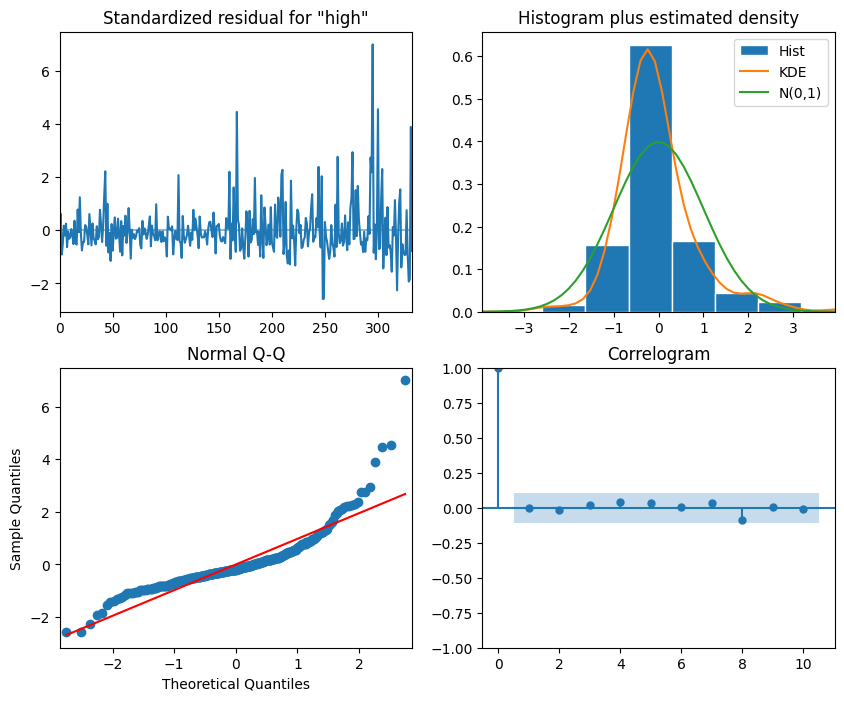

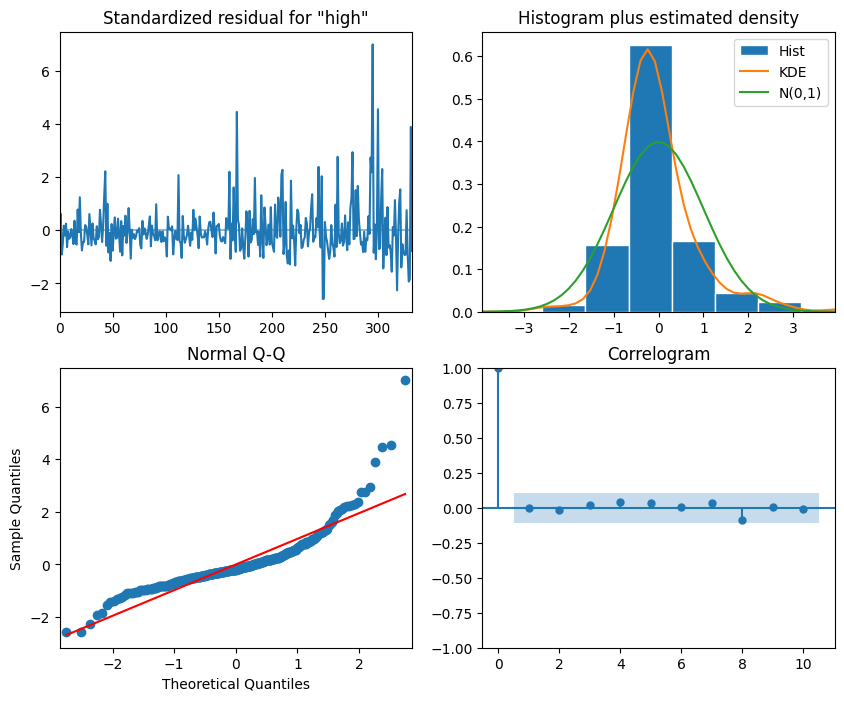

In [15]:
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0)

Residual Analysis for volume

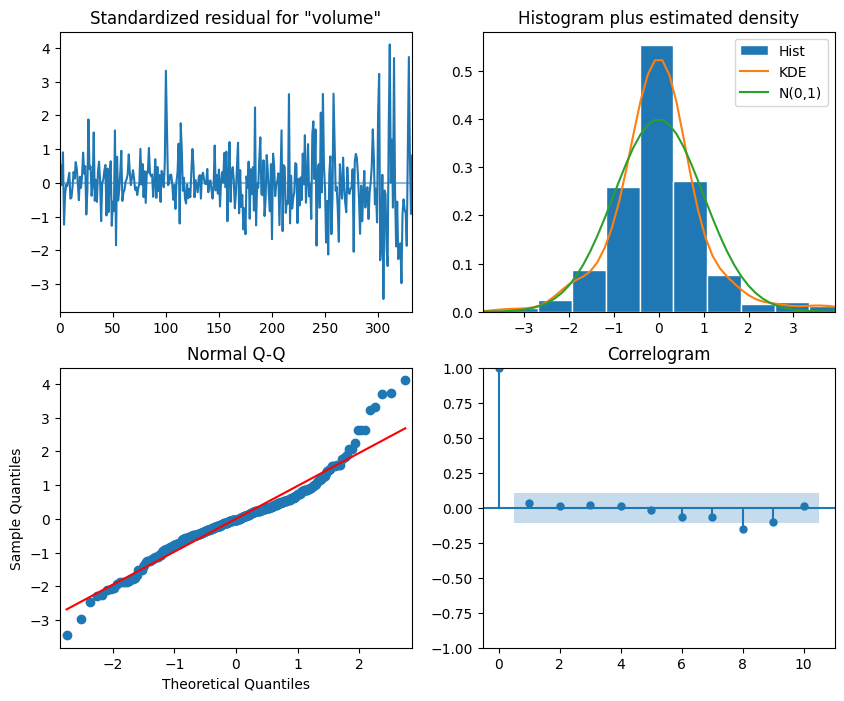

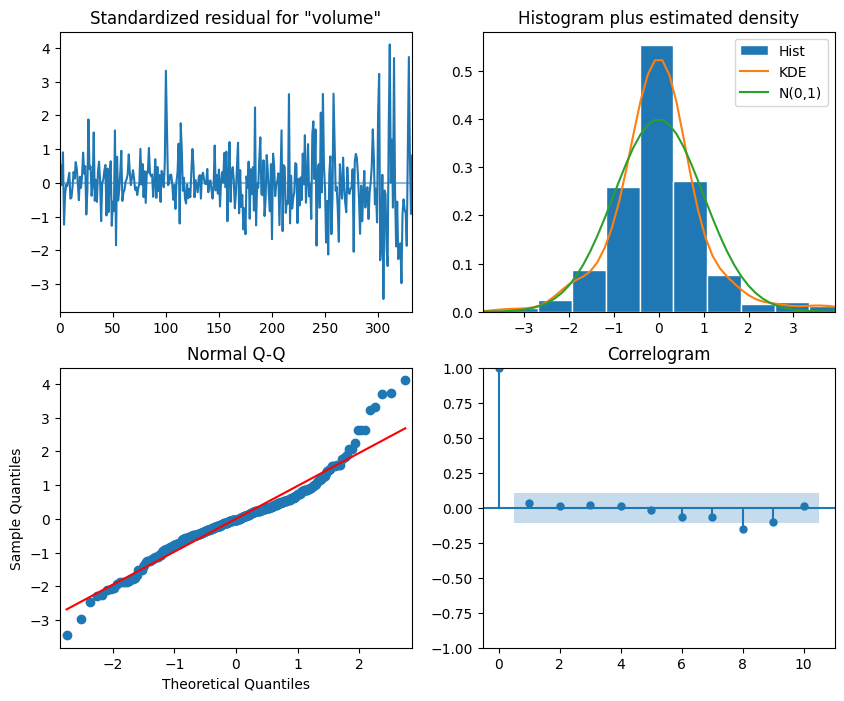

In [16]:
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1)

In [18]:
from statsmodels.stats.diagnostic import acorr_ljungbox

high_residuals = best_model_fit.resid['high']
acorr_ljungbox(high_residuals, np.arange(1, 11, 1))

lb_stat  lb_pvalue
1   0.000081   0.992807
2   0.054744   0.972999
3   0.186454   0.979746
4   0.700993   0.951206
5   1.073553   0.956418
6   1.097898   0.981627
7   1.518927   0.981647
8   4.114396   0.846657
9   4.116037   0.903610
10  4.154564   0.940105

In [19]:
volume_residuals = best_model_fit.resid['volume']
acorr_ljungbox(volume_residuals, np.arange(1, 11, 1))

lb_stat  lb_pvalue
1    0.040331   0.840835
2    0.607485   0.738051
3    0.939449   0.815899
4    1.568192   0.814497
5    1.621447   0.898644
6    2.185740   0.901848
7    3.636990   0.820510
8    8.669610   0.370929
9   12.454352   0.188890
10  15.003649   0.131929

In [6]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    end_idx = train_len
    if method == 'VAR':
        high_pred_VAR = [] 
        volume_pred_VAR = []
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(6,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred_high = predictions.predicted_mean.iloc[-window:]['high']
            oos_pred_volume = predictions.predicted_mean.iloc[-window:]['volume']
            high_pred_VAR.extend(oos_pred_high) 
            volume_pred_VAR.extend(oos_pred_volume)
        return high_pred_VAR, volume_pred_VAR
    elif method == 'last':
        high_pred_last = []
        volume_pred_last = []
        for i in range(train_len, total_len, window):
            high_last = df[:i].iloc[-1]['high']
            volume_last = df[:i].iloc[-1]['volume']
            high_pred_last.extend(high_last for _ in range(window))
            volume_pred_last.extend(volume_last for _ in range(window))
        return high_pred_last, volume_pred_last

In [18]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 6
high_pred_VAR, volume_pred_VAR = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR')

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

In [19]:
test = endog[-30:]
test['high_pred_VAR'] = pd.Series()
test['high_pred_VAR'] = endog.iloc[333]['high'] + np.cumsum(high_pred_VAR)

test['volume_pred_VAR'] = pd.Series()
test['volume_pred_VAR'] = endog.iloc[162]['volume'] + np.cumsum(volume_pred_VAR)

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_4556\2108321665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['high_pred_VAR'] = pd.Series()
C:\Users\baloochyb\AppData\Local\Temp\ipykernel_4556\2108321665.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['high_pred_VAR'] = endog.iloc[333]['high'] + np.cumsum(high_pred_VAR)
C:\Users\baloochyb\AppData\Local\Temp\ipykernel_4556\2108321665.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [20]:
high_pred_last, volume_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last') 
test['high_pred_last'] = high_pred_last
test['volume_pred_last'] = volume_pred_last

test

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_4556\2402804614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['high_pred_last'] = high_pred_last
C:\Users\baloochyb\AppData\Local\Temp\ipykernel_4556\2402804614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['volume_pred_last'] = volume_pred_last


high        volume  high_pred_VAR  volume_pred_VAR  \
334  69629.602049  1.996779e+10   67864.683925     8.310124e+09   
335  70284.426265  2.120493e+10   67885.663109     4.825986e+09   
336  72715.359609  3.726143e+10   68955.194001     1.396090e+10   
337  71742.506324  3.642690e+10   69588.870685     1.573189e+10   
338  71093.433161  3.831860e+10   69573.769864     1.933522e+10   
339  71256.238130  3.015338e+10   69569.214852     1.656629e+10   
340  71222.742979  4.412930e+10   69438.040542     1.825721e+10   
341  67931.429364  5.286974e+10   69196.531576     1.292275e+10   
342  65824.427083  4.908432e+10   69299.944860     1.487472e+10   
343  66878.646905  4.359592e+10   69738.347222     1.962197e+10   
344  64355.669263  4.284753e+10   70023.342771     1.956211e+10   
345  64486.364710  4.191525e+10   70081.011819     2.107288e+10   
346  64125.686415  3.600631e+10   70031.402308     1.663280e+10   
347  65481.597054  4.992043e+10   70940.235407     1.929552e+10   
348  65442.458954  2.309749e+10   71331.710819     1.885048e+10   
349  65723.239828  2.050664e+10   71638.153423     2.672486e+10   
350  67233.957036  2.828269e+10   71888.631260     2.092137e+10   
351  67199.241946  2.431098e+10   72153.514161     2.076829e+10   
352  67075.369646  3.027666e+10   73025.104661     2.852613e+10   
353  65275.207518  3.215579e+10   73655.769637     3.382761e+10   
354  64789.657506  2.413937e+10   73439.016383     3.623446e+10   
355  63898.361592  1.953078e+10   73001.626799     2.746358e+10   
356  64321.482808  1.733483e+10   72867.363752     2.470590e+10   
357  64174.877721  2.663591e+10   72863.486672     2.539492e+10   
358  64703.332363  3.784084e+10   73009.982613     2.778973e+10   
359  60780.499677  4.843978e+10   73176.771779     2.246122e+10   
360  59602.298028  3.271181e+10   73431.928131     2.550631e+10   
361  63320.503389  3.317202e+10   73327.687393     2.177028e+10   
362  64494.958426  2.062048e+10   73279.177744     2.023401e+10   
363  64610.890215  1.829616e+10   73646.341148     2.057636e+10   

     high_pred_last  volume_pred_last  
334    69291.254806      3.443953e+10  
335    69291.254806      3.443953e+10  
336    69291.254806      3.443953e+10  
337    69291.254806      3.443953e+10  
338    69291.254806      3.443953e+10  
339    69291.254806      3.443953e+10  
340    71093.433161      3.831860e+10  
341    71093.433161      3.831860e+10  
342    71093.433161      3.831860e+10  
343    71093.433161      3.831860e+10  
344    71093.433161      3.831860e+10  
345    71093.433161      3.831860e+10  
346    64355.669263      4.284753e+10  
347    64355.669263      4.284753e+10  
348    64355.669263      4.284753e+10  
349    64355.669263      4.284753e+10  
350    64355.669263      4.284753e+10  
351    64355.669263      4.284753e+10  
352    67233.957036      2.828269e+10  
353    67233.957036      2.828269e+10  
354    67233.957036      2.828269e+10  
355    67233.957036      2.828269e+10  
356    67233.957036      2.828269e+10  
357    67233.957036      2.828269e+10  
358    64321.482808      1.733483e+10  
359    64321.482808      1.733483e+10  
360    64321.482808      1.733483e+10  
361    64321.482808      1.733483e+10  
362    64321.482808      1.733483e+10  
363    64321.482808      1.733483e+10

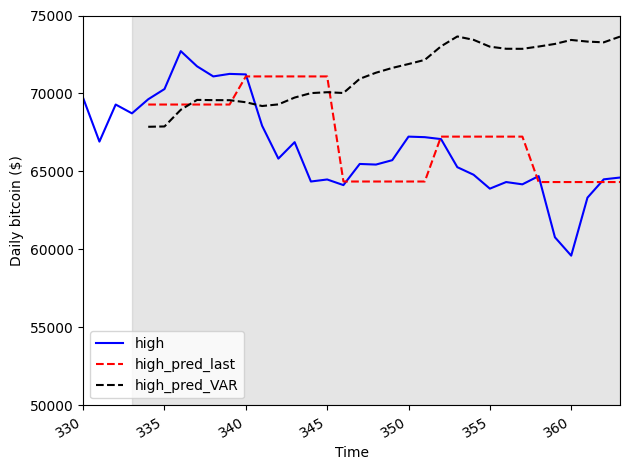

In [21]:
fig, ax = plt.subplots()

ax.plot(endog['high'], 'b-', label='high')
ax.plot(test['high_pred_last'], 'r--', label='high_pred_last')
ax.plot(test['high_pred_VAR'], 'k--', label='high_pred_VAR')
ax.legend(loc=3)
ax.set_xlabel('Time')
ax.set_ylabel('Daily bitcoin ($)')
ax.axvspan(333, 363, color='#808080', alpha=0.2)
ax.set_xlim(330, 363)
ax.set_ylim(50000, 75000)
# plt.xticks([333, 363], ['2024-05-04', '2024-05-05'])
fig.autofmt_xdate()
plt.tight_layout()

In [22]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_high_VAR = mape(test['high'], test['high_pred_VAR'])
mape_high_last = mape(test['high'], test['high_pred_last'])
mape_volume_VAR = mape(test['volume'], test['volume_pred_VAR'])
mape_volume_last = mape(test['volume'], test['volume_pred_last'])
print(mape_high_VAR)
print(mape_high_last)
print(mape_volume_VAR)
print(mape_volume_last)

9.19493021679904
3.5887987143204736
40.55955491602533
33.52615805069435


## Deep Learning ##

In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [3]:
bitcoin = pd.read_csv('Bitcoin2.csv', sep=';')
bitcoin = bitcoin.iloc[::-1].reset_index(drop=True)

In [4]:
bitcoin.describe().transpose()

count          mean           std           min           25%  \
name       364.0  2.781000e+03  0.000000e+00  2.781000e+03  2.781000e+03   
open       364.0  3.992349e+04  1.450824e+04  2.512167e+04  2.761312e+04   
high       364.0  4.068136e+04  1.496217e+04  2.573531e+04  2.804059e+04   
low        364.0  3.918378e+04  1.395998e+04  2.479717e+04  2.711516e+04   
close      364.0  4.002157e+04  1.455089e+04  2.512468e+04  2.761224e+04   
volume     364.0  2.200341e+10  1.416336e+10  5.331173e+09  1.268013e+10   
marketCap  364.0  7.830548e+11  2.885391e+11  4.874765e+11  5.362100e+11   

                    50%           75%           max  
name       2.781000e+03  2.781000e+03  2.781000e+03  
open       3.506890e+04  4.504555e+04  7.307937e+04  
high       3.571017e+04  4.667810e+04  7.375007e+04  
low        3.460547e+04  4.421574e+04  7.133409e+04  
close      3.525973e+04  4.551111e+04  7.308350e+04  
volume     1.758297e+10  2.604417e+10  1.028029e+11  
marketCap  6.886910e+11  8.927079e+11  1.436272e+12

In [5]:
cols_to_drop = ['timeOpen', 'timeClose', 'timeLow', 'timestamp', 'name', 'marketCap']
bitcoin = bitcoin.drop(cols_to_drop, axis=1)

In [6]:
import datetime
timestamp_s = pd.to_datetime(bitcoin['timeHigh']).map(datetime.datetime.timestamp)

In [7]:
month = 30 * 24 * 60 * 60
bitcoin['month_sin'] = (np.sin(timestamp_s * (2*np.pi/month))).values
# bitcoin['month_cos'] = (np.cos(timestamp_s * (2*np.pi/month))).values
bitcoin = bitcoin.drop(['timeHigh'], axis=1)
# bitcoin.sample(50).plot.scatter('month_sin').set_aspect('equal')

In [8]:
n = len(bitcoin)
# Split 70:20:10 (train:validation:test)
train_df = bitcoin[0:int(n*0.7)]
val_df = bitcoin[int(n*0.7):int(n*0.9)]
test_df = bitcoin[int(n*0.9):]

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df)
train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [10]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='high', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

baseline models

Single-step baseline model

In [11]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['high'])

In [12]:
wide_window = DataWindow(input_width=30, label_width=30, shift=1, label_columns=['high'])

In [13]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [14]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}
baseline_last = Baseline(label_index=column_indices['high'])
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [15]:
val_performance = {}
performance = {}
val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0047 - mean_absolute_error: 0.0426  


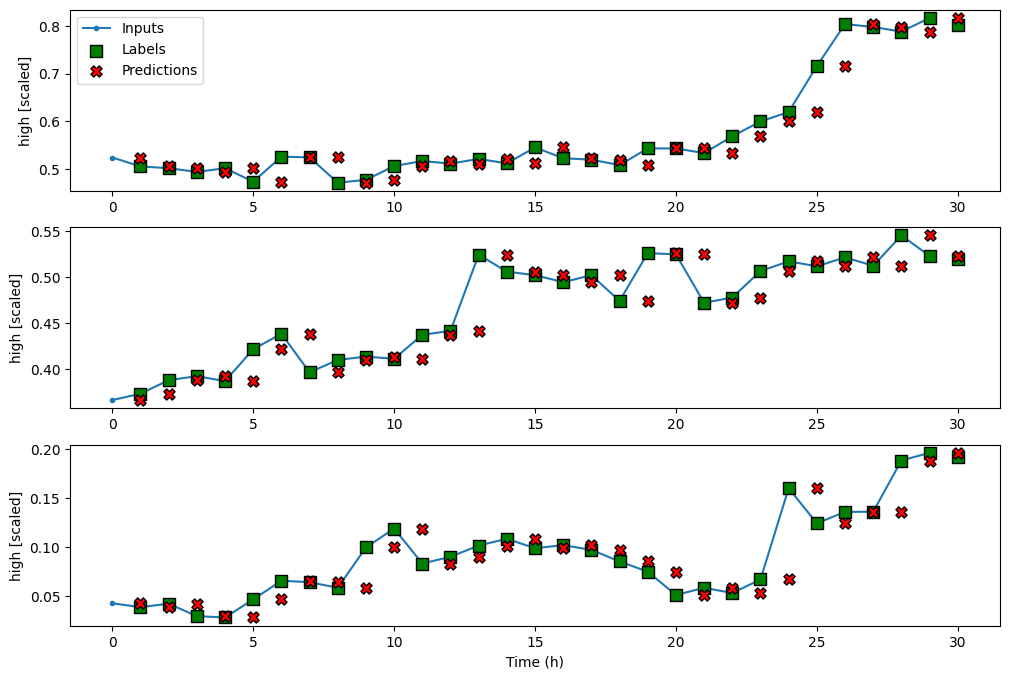

In [16]:
wide_window.plot(baseline_last)

In [17]:
print(performance['Baseline - Last'][1])

0.049535542726516724


Multi-step baseline models

In [22]:
multi_window = DataWindow(input_width=15, label_width=15, shift=15, label_columns=['high'])

PREDICTING THE LAST KNOWN VALUE

In [26]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 15, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 15, 1])

In [27]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['high'])
ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [28]:
ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.4975 - mean_absolute_error: 0.5147  


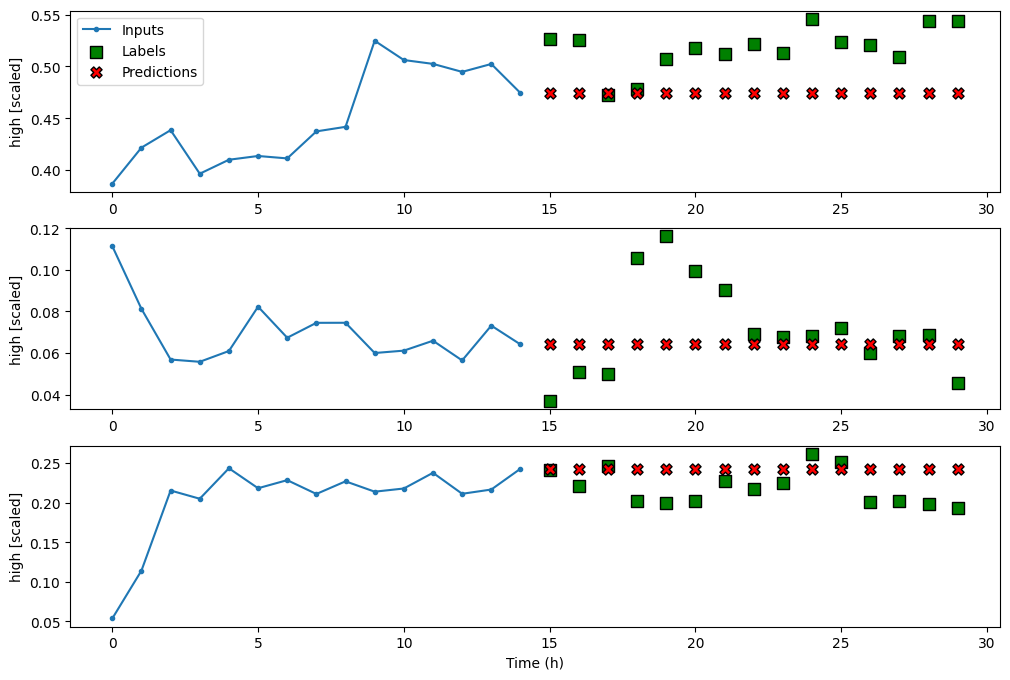

In [29]:
multi_window.plot(ms_baseline_last)

In [31]:
print(ms_val_performance['Baseline - Last'][1])

0.516384482383728


REPEATING THE INPUT SEQUENCE

In [32]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [33]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['high'])
ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.5406 - mean_absolute_error: 0.5991  


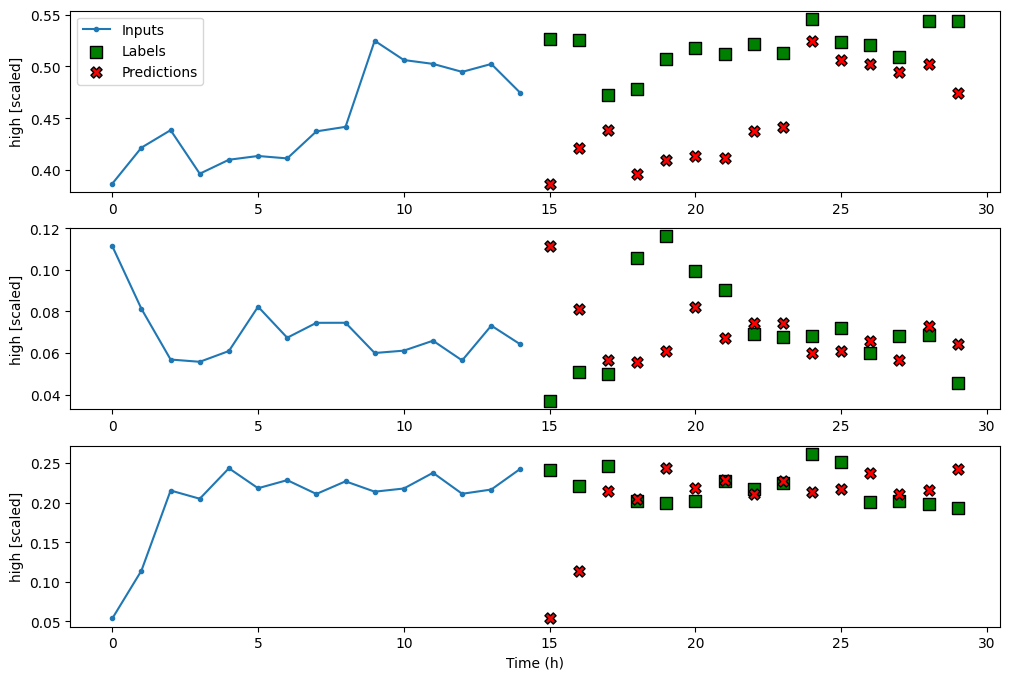

In [34]:
multi_window.plot(ms_baseline_repeat)

In [35]:
print(ms_val_performance['Baseline - Repeat'][1])

0.6024643778800964
